# Model and data load

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/pavelpopov/mlp_nn'

In [2]:
from omegaconf import OmegaConf
import torch
import pandas as pd
import seaborn as sns

from copy import deepcopy

from captum.attr import IntegratedGradients, NoiseTunnel, Saliency, visualization as viz
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

from src.data import data_factory, data_postfactory
from src.dataloader import dataloader_factory
from src.model import model_config_factory, model_factory

from scipy import stats

# colors = [(0.0, 'darkviolet'), (0.5, 'black'), (0.99, 'darkorange'), (1.0, 'white')]
from matplotlib.colors import LinearSegmentedColormap
corr_colors = [(0.0, 'blue'), (0.5, 'black'), (0.99, 'red'), (1.0, 'white')]
abs_corr_colors = [(0.0, 'black'), (0.99, 'red'), (1.0, 'white')]
corr_cmap = LinearSegmentedColormap.from_list('custom_colormap', corr_colors, N=256)
abs_corr_cmap = LinearSegmentedColormap.from_list('custom_colormap', abs_corr_colors, N=256)

import os, sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
corr_cmap = "inferno"
abs_corr_cmap = "inferno"

In [4]:
def load_model_and_data(path):
    cfg = OmegaConf.load(path+'/general_config.yaml')

    df = pd.read_csv(path+'/runs.csv')
    best_idx = df["test_score"].idxmax()
    k = best_idx // cfg.mode.n_trials
    trial = best_idx - cfg.mode.n_trials * k
    print("k ", k)
    print("trial ", trial)

    original_data = data_factory(cfg)
    model_cfg = model_config_factory(cfg, k)
    data = data_postfactory(
            cfg,
            model_cfg,
            original_data,
        )
    dataloaders = dataloader_factory(cfg, data, k=k, trial=trial)

    model = model_factory(cfg, model_cfg)

    model_logpath = path+f"/k_{k:02d}/trial_{trial:04d}/best_model.pt"
    checkpoint = torch.load(
        model_logpath, map_location=lambda storage, loc: storage
    )
    model.load_state_dict(checkpoint)

    return model, dataloaders, checkpoint

In [5]:
neuromark = pd.read_csv("/Users/pavelpopov/mlp_nn/assets/data/neuromark_regions.csv")
neuromark["Index"]=neuromark["Index"]-1
neuromark = {a: (b, c, d, e, f) for a, b, c, d, e, f in zip(neuromark["Index"], neuromark["Name"], neuromark["Network"], neuromark["X"], neuromark["Y"], neuromark["Z"])}

# Introspection

Plotting saliency
Plotting test data
Plotting spatial attention


/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'Component'

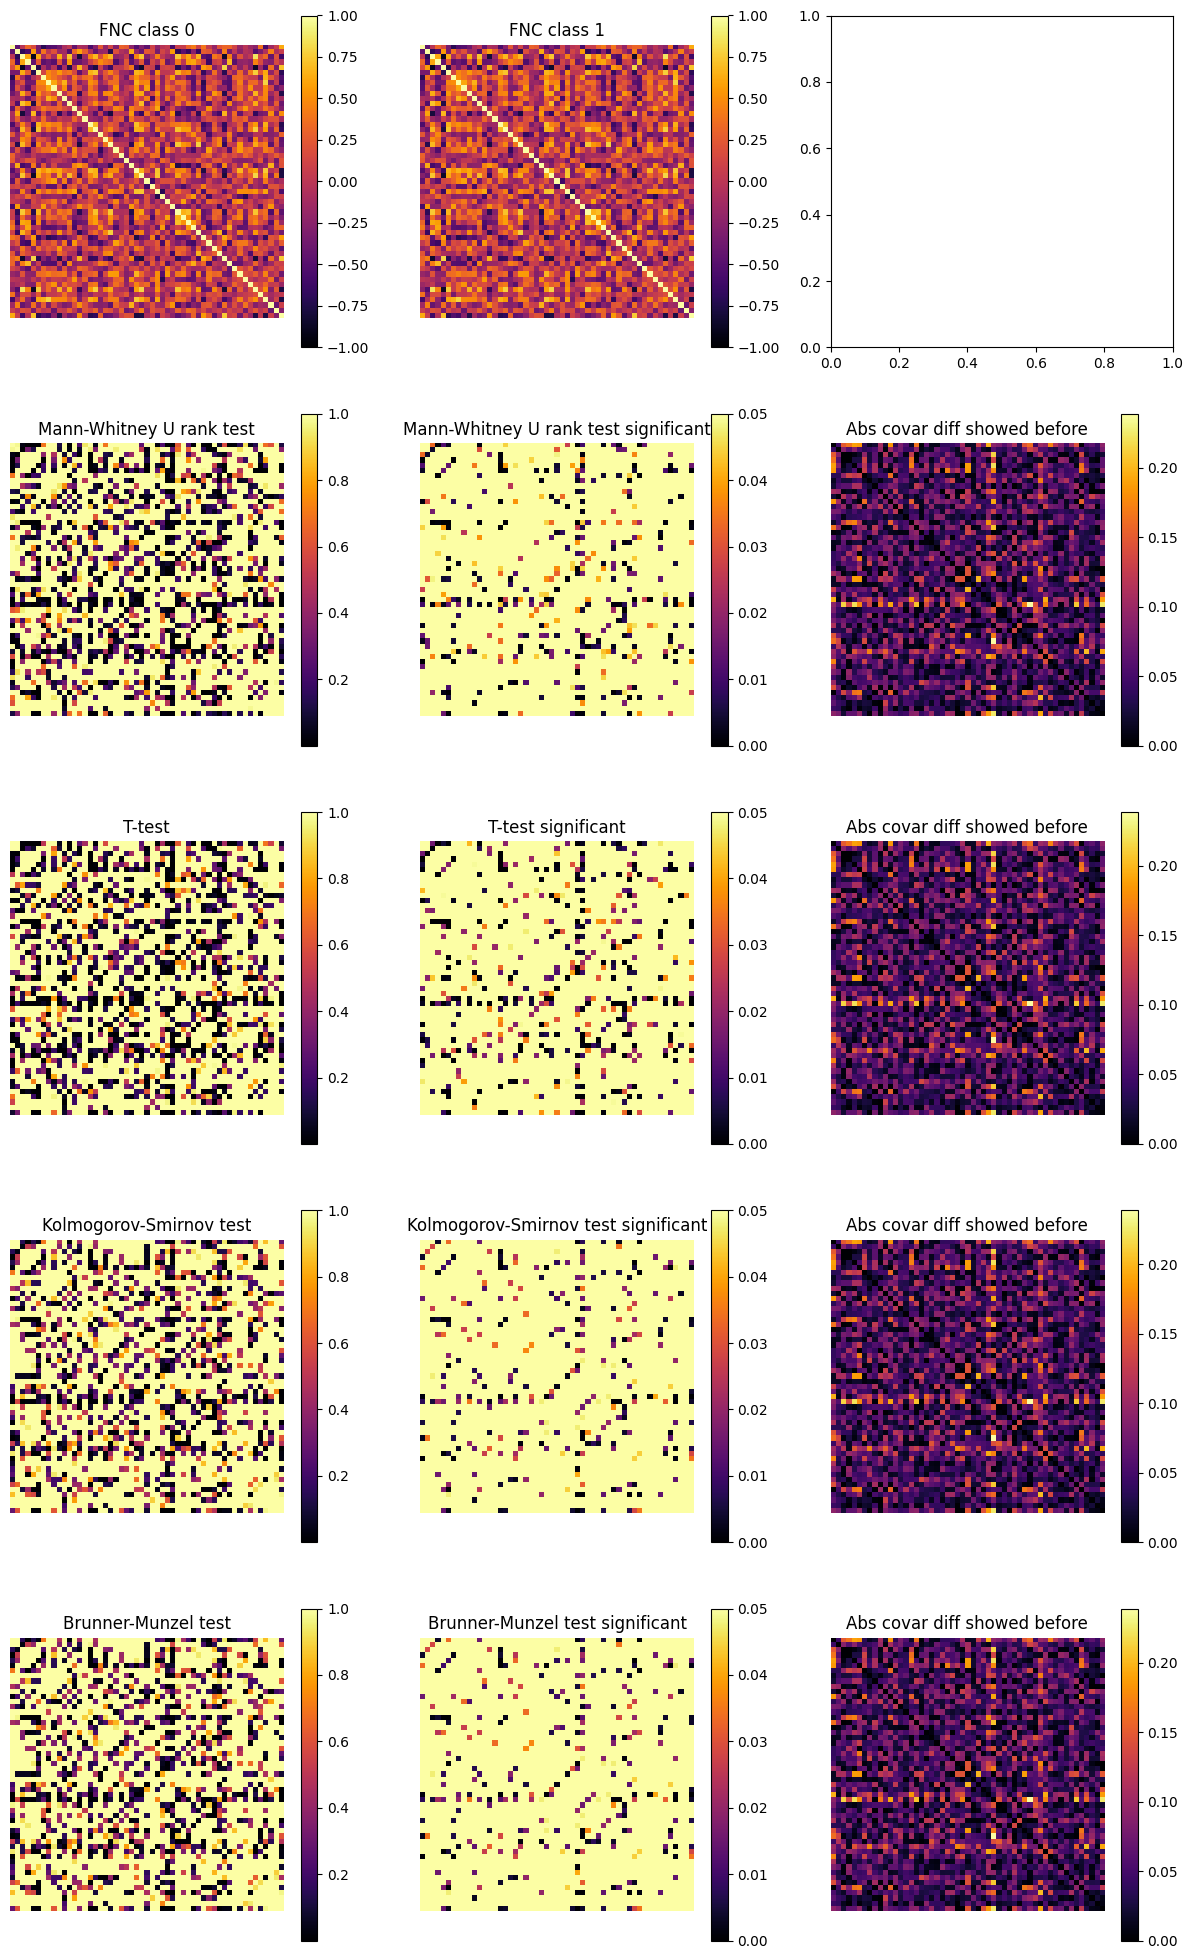

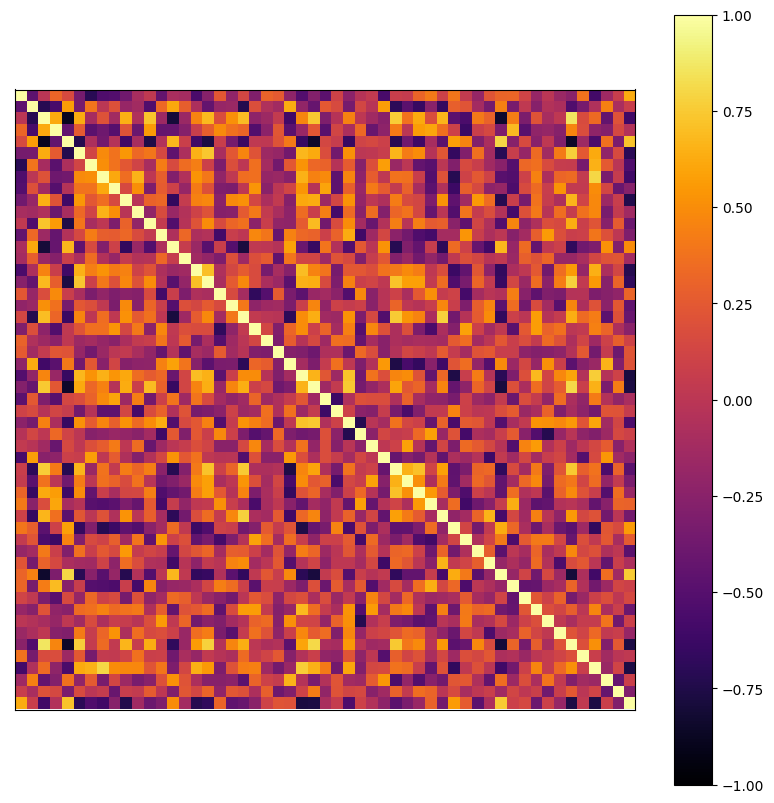

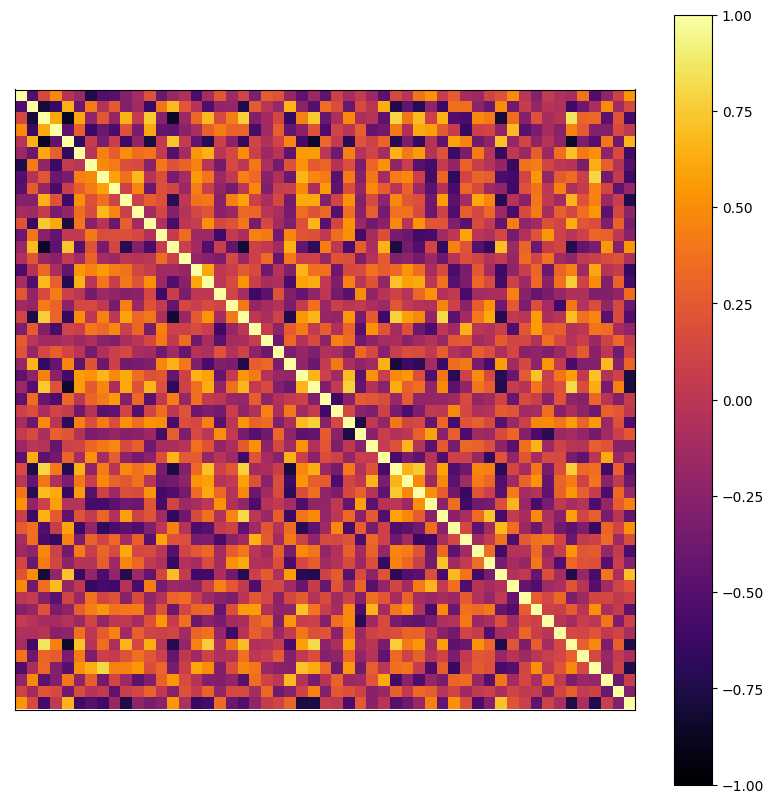

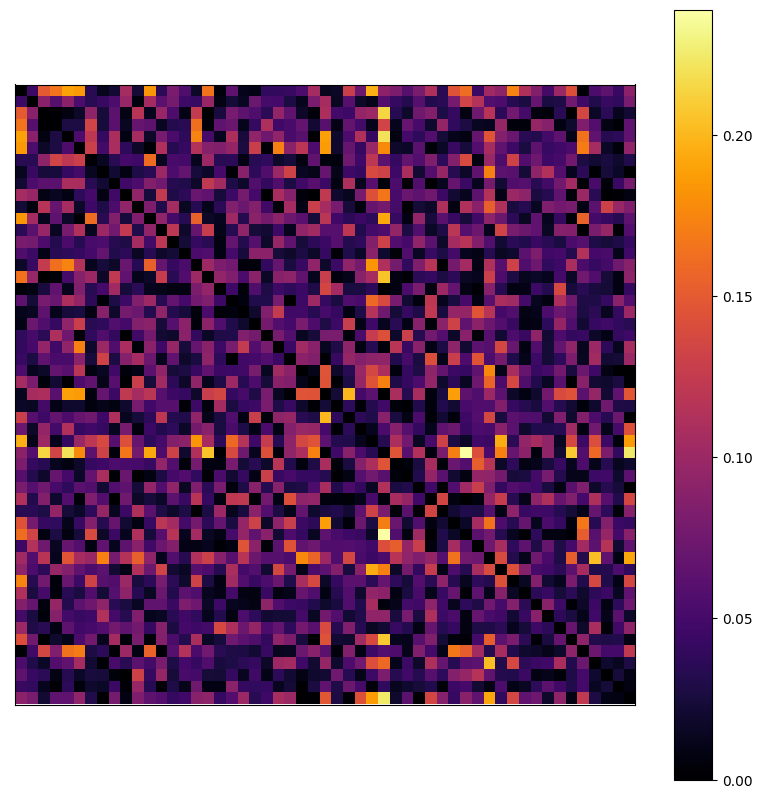

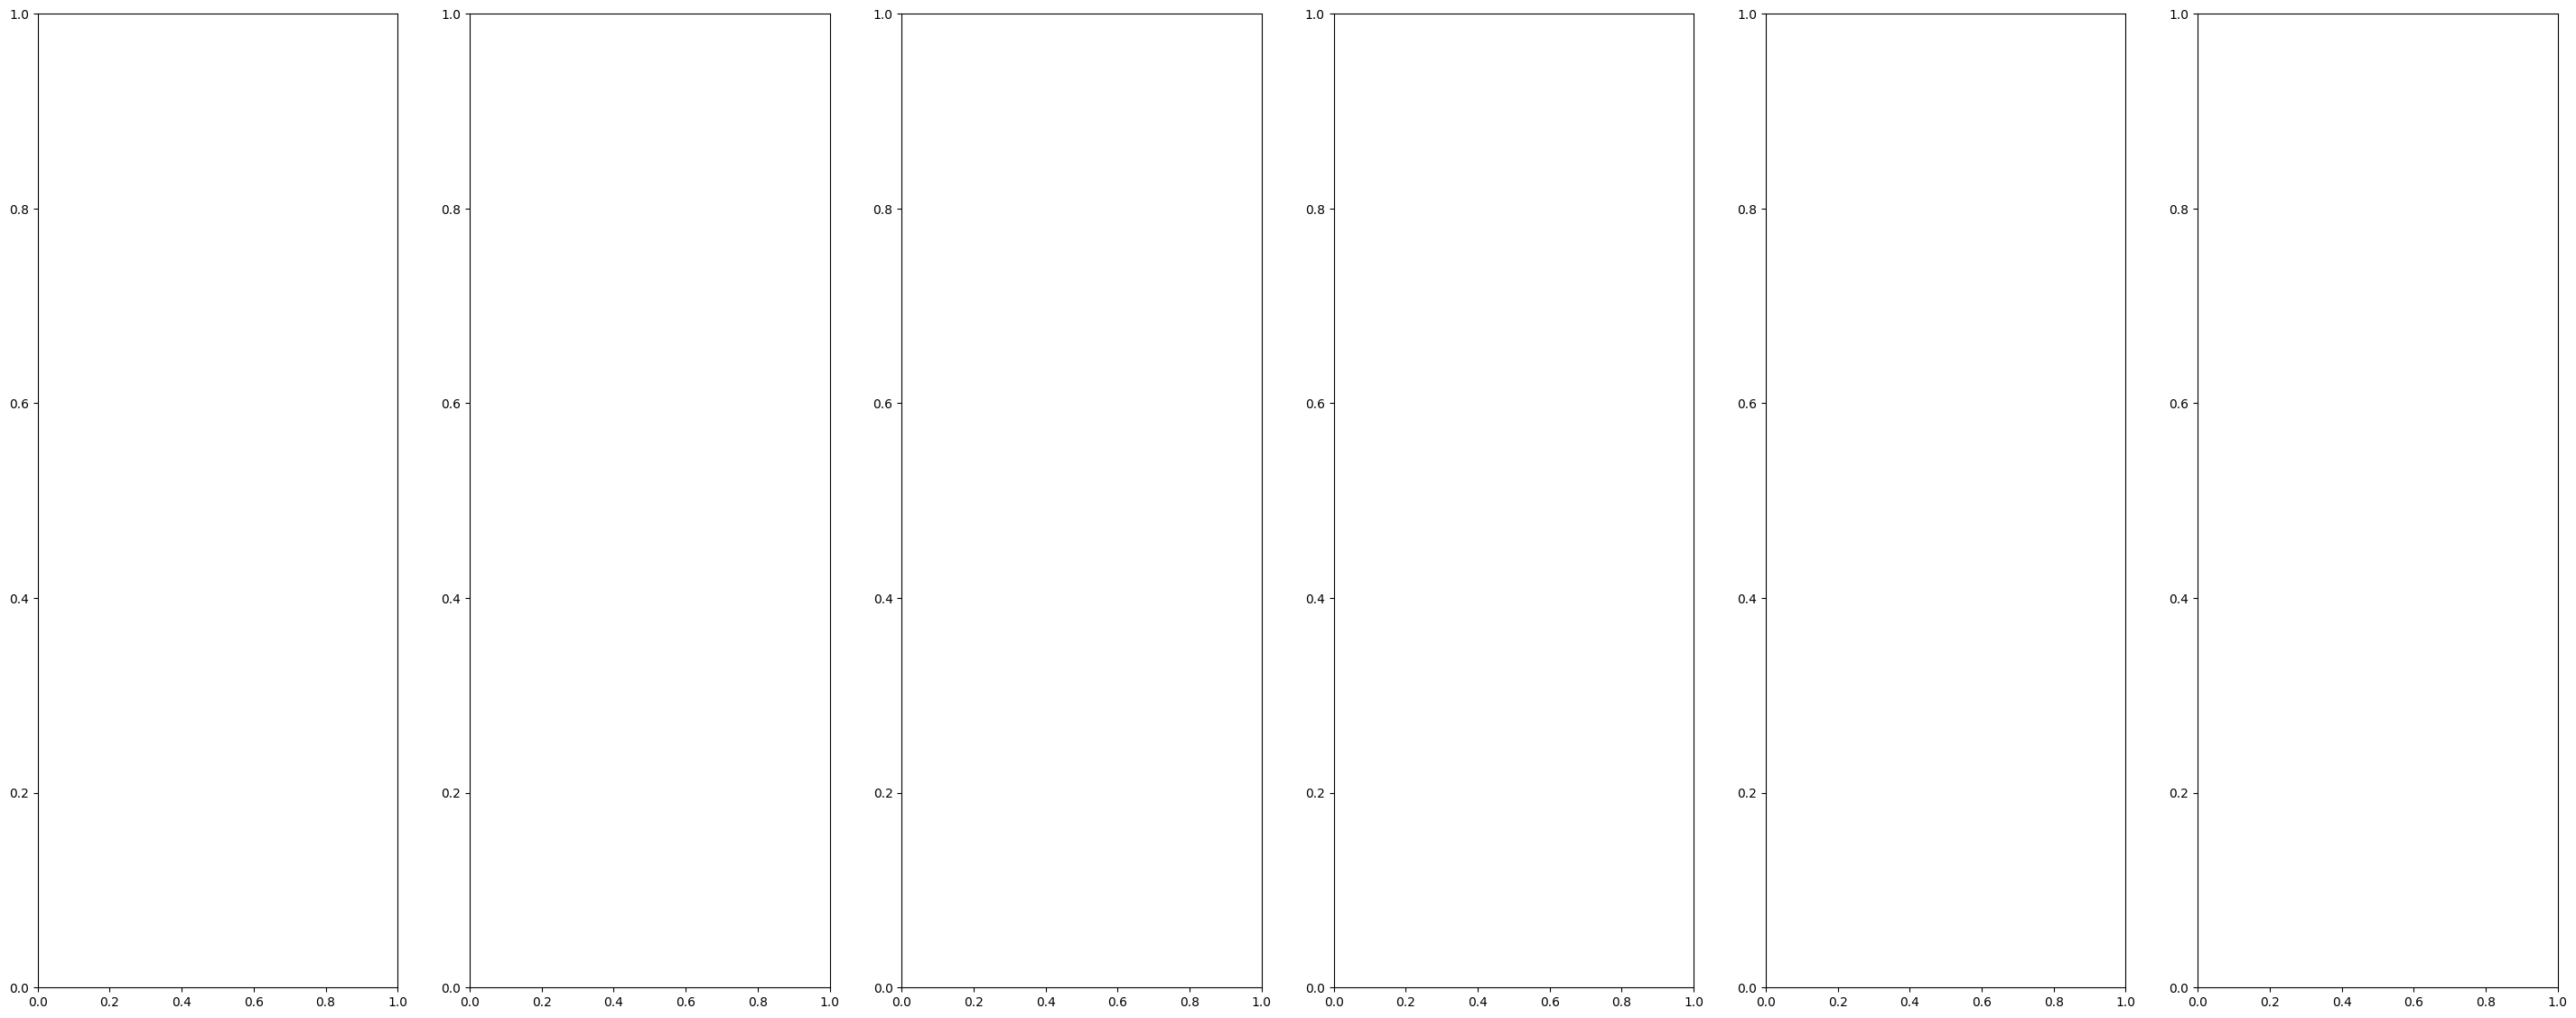

In [9]:
class IntrospectorV2:
    """Basic introspector"""

    def __init__(self, path, methods, save_path) -> None:
        self.path = path
        self.methods = methods
        self.save_path = save_path

        if "saliency" in self.methods:
            os.makedirs(f"{self.save_path}saliency", exist_ok=True)
        if "ig" in self.methods:
            os.makedirs(f"{self.save_path}ig", exist_ok=True)
        if "ignt" in self.methods:
            os.makedirs(f"{self.save_path}ignt", exist_ok=True)
        
        self.compute_data(path)
        for ds_key in self.features:
            for method in methods:
                for class_idx in range(2):
                    np.save(f"{self.save_path}{method}/{ds_key}_features_{class_idx}.npy", self.features[ds_key][class_idx].cpu().detach().numpy())
                    np.save(f"{self.save_path}{method}/{ds_key}_grads_{class_idx}.npy", self.grads[ds_key][method][class_idx])
    
    def compute_data(self, path, load_only_test = True):
        cfg = OmegaConf.load(path+'/general_config.yaml')

        n_splits = cfg.mode.n_splits
        n_trials = cfg.mode.n_trials

        self.grads = {}
        self.features, self.timeseries, self.smooth_timeseries, self.predictions = {}, {}, {}, {}

        # datasets = ["test"]
        datasets = ["test", "train", "valid"]
        if (
            "compatible_datasets" in cfg.dataset
            and cfg.dataset.compatible_datasets is not None
        ):
            datasets += cfg.dataset.compatible_datasets

        for ds_key in datasets:
            self.features[ds_key], self.timeseries[ds_key], self.smooth_timeseries[ds_key], self.predictions[ds_key] = None, None, None, None
            self.grads[ds_key] = {key: [] for key in self.methods}
            
        # for k in range(n_splits):
        for k in range(1):
            k = 3
            # for trial in range(n_trials):
            for trial in range(1):
                trial = 7
                model, data, _ = self.load_model_and_data(path, cfg, k, trial)

                for ds_key in data:
                    # if ds_key in ["train", "valid"]:
                    #     continue
                    
                    dataset = data[ds_key].dataset
                    features = [sample[0] for sample in dataset]
                    labels = [sample[1] for sample in dataset]

                    features = torch.stack(features)
                    labels = torch.stack(labels)
                    targets = torch.unique(labels)
                    self.n_classes = n_classes = targets.shape[0]

                    class_features, timeseries, smooth_timeseries, predictions = (
                        [None]*n_classes, 
                        [None]*n_classes, 
                        [None]*n_classes, 
                        [None]*n_classes,
                    )

                    window_size = 10
                    for class_idx in range(n_classes):
                        filter_array = labels == class_idx
                        class_features[class_idx] = features[filter_array]
                        class_features[class_idx].requires_grad = False

                    #     timeseries_raw, predictions[class_idx] = model(class_features[class_idx], introspection=True)
                    #     timeseries_raw = timeseries_raw.cpu().detach().numpy()
                    #     predictions[class_idx] = predictions[class_idx].cpu().detach().numpy()
                        
                    #     # timeseries_raw was calculated for the data related to class_idx;
                    #     # yet it has `n_classes` class prediction time series in 3rd dimension
                    #     # so timeseries[class_idx] is a list of length n_classes, each element of which
                    #     # represents the class prediction time series
                    #     timeseries[class_idx] = [timeseries_raw[:, :, j] for j in range(n_classes)]

                    #     smooth_timeseries[class_idx] = deepcopy(timeseries[class_idx])
                    #     for j in range(n_classes):
                    #         for subject in range(smooth_timeseries[class_idx][j].shape[0]):
                    #             smooth_timeseries[class_idx][j][subject] = np.convolve(smooth_timeseries[class_idx][j][subject], np.ones(window_size)/window_size, mode='same')

                    if self.features[ds_key] is None:
                        self.features[ds_key] = class_features
                        # self.timeseries[ds_key] = timeseries
                        # self.smooth_timeseries[ds_key] = smooth_timeseries
                        # self.predictions[ds_key] = predictions
                    else:
                        for class_idx in range(n_classes):
                            self.features[ds_key][class_idx] = torch.concatenate((self.features[ds_key][class_idx], class_features[class_idx]), axis=0)
                            # self.timeseries[ds_key][class_idx] = np.concatenate((self.timeseries[ds_key][class_idx], timeseries[class_idx]), axis=1)
                            # self.smooth_timeseries[ds_key][class_idx] = np.concatenate((self.smooth_timeseries[ds_key][class_idx], smooth_timeseries[class_idx]), axis=1)
                            # self.predictions[ds_key][class_idx] = np.concatenate((self.predictions[ds_key][class_idx], predictions[class_idx]), axis=0)

                    # print(f"self.features[{ds_key}][0]: {self.features[ds_key][0].shape}")

                    grads = {key: [] for key in self.methods}
                    for method in self.methods:
                        for j in range(n_classes):
                            class_features[j].requires_grad = True
                            grads[method].append(self.get_grads(model, method, class_features[j], j).cpu().detach().numpy())

                        if len(self.grads[ds_key][method]) == 0:
                            self.grads[ds_key][method] += grads[method]
                        else:
                            for j in range(n_classes):
                                self.grads[ds_key][method][j] = np.concatenate((self.grads[ds_key][method][j], grads[method][j]), axis=0)
                    
                    # print(f"self.grads[{ds_key}][0]: {self.grads[ds_key]['saliency'][0].shape}")
        


    def load_model_and_data(self, path, cfg, k, trial):
        with HiddenPrints():
            original_data = data_factory(cfg)
            model_cfg = model_config_factory(cfg, k)
            data = data_postfactory(
                    cfg,
                    model_cfg,
                    original_data,
                )
            dataloaders = dataloader_factory(cfg, data, k=k, trial=trial)

            model = model_factory(cfg, model_cfg)

            model_logpath = path+f"/k_{k:02d}/trial_{trial:04d}/best_model.pt"
            checkpoint = torch.load(
                model_logpath, map_location=lambda storage, loc: storage
            )
            model.load_state_dict(checkpoint)

        return model, dataloaders, checkpoint


    def plot_timeseries(self, timeseries, smooth_timeseries, grads, features, predictions, target, filepath, cutoff, use_log=False):
        fig, ax = plt.subplots(2, cutoff,figsize=(3*cutoff, 4))

        x = np.arange(timeseries[0].shape[1])
        for i in range(cutoff):
            smooth_line_0 = ax[0][i].plot(x[:140], smooth_timeseries[0][i][:140], label='0', color='blue')
            smooth_line_1 = ax[0][i].plot(x[:140], smooth_timeseries[1][i][:140], label='1', color='red')
            line_0 = ax[0][i].plot(x[:140], timeseries[0][i][:140], '#00009922')
            line_1 = ax[0][i].plot(x[:140], timeseries[1][i][:140], '#99000022')

            # ax[i].set_title(f"True target = {target}, Predicted target = {predictions[i]}")
            ax[0][i].legend(title="Prediction")
            
            ax[0][i].set_xlim(0, 140)
            ax[0][i].set_xticklabels([])
            ax[0][i].set_xticks([])
            ax[0][i].set_yticklabels([])
            ax[0][i].set_yticks([])
            ax[0][i].set_xlabel("Time")
            ax[0][i].set_ylabel("Prediction strength" if i == 0 else "")

            # grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            feat = features[i].cpu().detach().numpy()[np.newaxis, :, :]
            _, _ = viz.visualize_image_attr(
                np.transpose(grad, (2, 1, 0))[:,:140, :],
                np.transpose(feat, (2, 1, 0))[:,:140, :],
                method="heat_map",
                cmap="inferno",
                show_colorbar=False,
                plt_fig_axis=(fig, ax[1][i]),
                use_pyplot=False,
            )
            ax[0][i].grid()

        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )
  
    def plot_histograms(self, grads, filepath, method, percentile=0.1):
        sns.reset_defaults()

        data_0 = grads[0]
        data_1 = grads[1]

        corr_0 = np.corrcoef(grads[0].reshape(-1, grads[0].shape[2]).T)
        corr_1 = np.corrcoef(grads[1].reshape(-1, grads[1].shape[2]).T)
        difcor = np.abs(corr_0-corr_1)



        pearson_0 = np.zeros((data_0.shape[0], data_0.shape[2], data_0.shape[2]))
        pearson_1 = np.zeros((data_1.shape[0], data_1.shape[2], data_1.shape[2]))
        for i in range(pearson_0.shape[0]):
            pearson_0[i, :, :] = np.corrcoef(data_0[i, :, :], rowvar=False)
        for i in range(pearson_1.shape[0]):
            pearson_1[i, :, :] = np.corrcoef(data_1[i, :, :], rowvar=False)

        np.save(f"{filepath}_fnc_grads_0.npy", pearson_0)
        np.save(f"{filepath}_fnc_grads_1.npy", pearson_1)
        
        # mannwhitney U rank test
        pvals_mw = []
        for i in range(pearson_0.shape[1]):
            pvals_mw.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.mannwhitneyu(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                )
                    
                pvals_mw[-1].append(test.pvalue)

            pvals_mw[-1] = np.array(pvals_mw[-1])
        pvals_mw = np.array(pvals_mw)

        # ttest_ind test
        pvals_ttest = []
        for i in range(pearson_0.shape[1]):
            pvals_ttest.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.ttest_ind(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                    equal_var=False
                )
                pvals_ttest[-1].append(test.pvalue)
            pvals_ttest[-1] = np.array(pvals_ttest[-1])
        pvals_ttest = np.array(pvals_ttest)
        
        # kstest
        pvals_ks = []
        for i in range(pearson_0.shape[1]):
            pvals_ks.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.kstest(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                )
                pvals_ks[-1].append(test.pvalue)
            pvals_ks[-1] = np.array(pvals_ks[-1])
        pvals_ks = np.array(pvals_ks)

        # brunnermunzel
        pvals_bm = []
        for i in range(pearson_0.shape[1]):
            pvals_bm.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.kstest(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                )
                pvals_bm[-1].append(test.pvalue)
            pvals_bm[-1] = np.array(pvals_bm[-1])
        pvals_bm = np.array(pvals_bm)

        tests = [
            ("Mann-Whitney U rank test", pvals_mw), 
            ("T-test", pvals_ttest),
            ("Kolmogorov-Smirnov test", pvals_ks),
            ("Brunner-Munzel test", pvals_bm),
        ]

        pearson_0 = pearson_0.mean(axis=0)
        pearson_1 = pearson_1.mean(axis=0)

        fig, ax = plt.subplots(5, 3, figsize=(15, 25))
        ims = []

        ims.append(ax[0][0].imshow(pearson_0, cmap=corr_cmap))
        ims[-1].set(clim=(-1.0, 1.0))
        ax[0][0].set_xticks([], [])
        ax[0][0].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[0][0].axis("off")
        ax[0][0].set_title("FNC class 0")
        
        ims.append(ax[0][1].imshow(pearson_0, cmap=corr_cmap))
        ims[-1].set(clim=(-1.0, 1.0))
        ax[0][1].set_xticks([], [])
        ax[0][1].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[0][1].axis("off")
        ax[0][1].set_title("FNC class 1")

        for test_idx in range(4):
            # correction
            pvals = tests[test_idx][1]
            # pvals = pvals.reshape(corr_shape, corr_shape)

            # setting to 1 manually, tests are sensitive to the rounding error variance
            pvals[np.diag_indices(pvals.shape[0])] = 1
            pvals[np.triu_indices_from(pvals, k=1)] = stats.false_discovery_control(pvals[np.triu_indices_from(pvals, k=1)], method='by')
            pvals_triu = np.triu(pvals, k=1)
            pvals[np.tril_indices_from(pvals, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]
            np.save(f"{filepath}_fnc_{tests[test_idx][0]}.npy", pvals)

            ims.append(ax[1+test_idx][0].matshow(pvals, cmap=corr_cmap))
            ax[1+test_idx][0].set_xticks([], [])
            ax[1+test_idx][0].set_yticks([], [])
            fig.colorbar(ims[-1])
            ax[1+test_idx][0].axis("off")
            ax[1+test_idx][0].set_title(f"{tests[test_idx][0]}")

            ims.append(ax[1+test_idx][2].matshow(difcor, cmap=corr_cmap))
            ax[1+test_idx][2].set_xticks([], [])
            ax[1+test_idx][2].set_yticks([], [])
            fig.colorbar(ims[-1])
            ax[1+test_idx][2].axis("off")
            ax[1+test_idx][2].set_title(f"Abs covar diff showed before")

            
            pvals[pvals > 0.05] = 1
            ims.append(ax[1+test_idx][1].matshow(pvals, cmap=corr_cmap))
            ims[-1].set(clim=(0, 0.05))
            ax[1+test_idx][1].set_xticks([], [])
            ax[1+test_idx][1].set_yticks([], [])
            fig.colorbar(ims[-1])
            ax[1+test_idx][1].axis("off")
            ax[1+test_idx][1].set_title(f"{tests[test_idx][0]} significant")
        fig.savefig(
            f"{filepath}_fnc.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        # CONCAT FNC    
        if len(grads[0].shape) == 3:
            data_0 = grads[0].reshape(-1, grads[0].shape[2])
            data_1 = grads[1].reshape(-1, grads[1].shape[2])
            x = np.arange(grads[0].shape[2])
        else:
            data_0 = grads[0]
            data_1 = grads[1]
            x = np.arange(grads[0].shape[1])
        
        corr_0 = np.corrcoef(data_0.T)
        corr_1 = np.corrcoef(data_1.T)

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(corr_0, cmap=corr_cmap)
        cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_cocat_fnc_0.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(corr_1, cmap=corr_cmap)
        cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_cocat_fnc_1.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(np.abs(corr_0-corr_1), cmap=abs_corr_cmap)
        # cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_cocat_fnc_diff.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        # fig, ax = plt.subplots(1, 4, figsize=(cutoff+3, 7))
        n_panels = 2+4
        fig, ax = plt.subplots(1, n_panels, figsize=(6*n_panels, 14))
        # fig, ax = plt.subplots(1, 2, figsize=(12, 14))

        if method != "ignt":
            data_1 = data_1 * -1.0

        df_0 = pd.DataFrame(data_0, columns=[i for i in range(data_0.shape[1])])
        df_0['Class'] = 0
        df_1 = pd.DataFrame(data_1, columns=[i for i in range(data_1.shape[1])])
        df_1['Class'] = 1
        df = pd.concat([df_0, df_1], ignore_index=True)
        df = pd.melt(df, id_vars=['Class'], var_name='Component', value_name='Data')
        sns.boxplot(df, y="Component", x="Data", hue="Class", ax=ax[0], palette=["blue", "red"], showfliers = False, orient='h', linewidth=0.3)
        ax[0].grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.3)
        ax[0].invert_yaxis()
        ax[0].set_yticks(x, x, fontsize=6)
        ax[0].set_ylim(-3, 55)
        ax[0].set_title("Gradients")

        # data has shape [observations, components]

        # mannwhitney U rank test
        test = stats.mannwhitneyu(data_0, data_1)
        pvals_mw = test.pvalue

        # ttest_ind test
        test = stats.ttest_ind(
            data_0, 
            data_1,
            equal_var=False
        )
        pvals_ttest = test.pvalue
        
        # kstest
        pvals_ks = []
        for i in range(data_0.shape[1]):
            test = stats.kstest(data_0[:, i], data_1[:, i])
            pvals_ks.append(test.pvalue)
        pvals_ks = np.array(pvals_ks)

        # brunnermunzel
        pvals_bm = []
        for i in range(data_0.shape[1]):
            test = stats.brunnermunzel(data_0[:, i], data_1[:, i])
            pvals_bm.append(test.pvalue)
        pvals_bm = np.array(pvals_bm)

        tests = [
            ("Mann-Whitney U rank test", pvals_mw), 
            ("T-test", pvals_ttest),
            ("Kolmogorov-Smirnov test", pvals_ks),
            ("Brunner-Munzel test", pvals_bm),
        
        ]
        for test_idx in range(4):
            # correction
            pvals = tests[test_idx][1]
            pvals = stats.false_discovery_control(pvals, method='by')
            significant_p_vals = np.argwhere(pvals < 0.05)
            # pvals = pvals / pvals.shape[0]

            bars = ax[test_idx+1].barh(
                x,
                pvals,
                align="center",
                color='blue',
            )
            ax[test_idx+1].set_yticks(x, [neuromark[k][0] if k in significant_p_vals else k for k in x], fontsize=6)
            ax[test_idx+1].set_xlabel("P-value")
            ax[test_idx+1].set_xscale("log")
            ax[test_idx+1].set_title(tests[test_idx][0])


            for i, bar in enumerate(bars):
                if pvals[i] < 0.05:
                    bar.set_color('red')
            # bar charts: summarizes gradients at each component

        data_0 = np.median(data_0, axis=0)
        data_1 = np.median(data_1, axis=0)
        
        min_0, max_0 = np.min(data_0), np.max(data_0)
        min_1, max_1 = np.min(data_1), np.max(data_1)
        min_v, max_v = min(min_0, min_1), max(max_0, max_1)
        if min_v <= 0:
            max_v = max(abs(min_v), abs(max_v))
            min_v = -1.0*max_v
        else:
            min_v = 0
                
        sym_data_0 = np.zeros(x.shape)
        sym_data_1 = np.zeros(x.shape)
        asym_data_0 = np.zeros(x.shape)
        asym_data_1 = np.zeros(x.shape)

        for j in x:
            sym_data_0[j] = np.sign(data_0[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            sym_data_1[j] = np.sign(data_1[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            asym_data_0[j] = data_0[j] - sym_data_0[j]
            asym_data_1[j] = data_1[j] - sym_data_1[j]

        abs_grad = np.abs(data_0) + np.abs(data_1)
        abs_sym_grad = np.abs(sym_data_0) + np.abs(sym_data_1)
        abs_asym_grad = np.abs(asym_data_0) + np.abs(asym_data_1)
        significant_comp = np.argsort(abs_grad)[-int(percentile*x.shape[0]):]
        significant_sym_comp = np.argsort(abs_sym_grad)[-int(percentile*x.shape[0]):]
        significant_asym_comp  = np.argsort(abs_asym_grad)[-int(percentile*x.shape[0]):]

        all_significant = np.intersect1d(significant_comp, np.intersect1d(significant_sym_comp, significant_asym_comp))
        all_significant = {
            "idx": all_significant,
            "name": [neuromark[k][0] for k in all_significant],
            "network": [neuromark[k][1] for k in all_significant],
            "x": [neuromark[k][2] for k in all_significant],
            "y": [neuromark[k][3] for k in all_significant],
            "z": [neuromark[k][4] for k in all_significant],
        }
        pd.DataFrame(all_significant).to_csv(f"{filepath}_significant.csv")


        ax[-1].barh(
            x,
            data_0,
            align="center",
            color='blue',
            label='0', 
            alpha=0.7,
        )

        ax[-1].barh(
            x,
            data_1,
            align="center",
            color='red',
            label='1', 
            alpha=0.7,
        )
        ax[-1].set_xlim(min_v, max_v)
        ax[-1].grid(axis='y', linestyle='--', alpha=0.5)
        ax[-1].set_yticks(x, [neuromark[k][0] if k in significant_comp else k for k in x], fontsize=6)
        ax[-1].set_title("Grad medians")


        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )
    
    def get_grads(self, model, method, features, target):
        """Returns gradients according to method"""
        model.zero_grad()

        if method == "saliency":
            saliency = Saliency(model)
            grads = saliency.attribute(features, target=target, abs=False)
        elif method == "ig":
            # ig = IntegratedGradients(self.model, multiply_by_inputs=False)
            ig = IntegratedGradients(model, multiply_by_inputs=True)
            grads, _ = ig.attribute(
                inputs=features,
                target=target,
                baselines=torch.zeros_like(features),
                return_convergence_delta=True,
            )
        elif method == "ignt":
            ig = Saliency(model)
            nt = NoiseTunnel(ig)
            grads = nt.attribute(
                inputs=features,
                target=target,
                abs=False,
                nt_type="vargrad",
                nt_samples=10,
                stdevs=0.3,
            )
        else:
            raise ValueError(f"'{method}' methods is not recognized")

        return grads

    def run(self, cutoff=1, percentile=0.1):
        """Run introspection, save results"""

        # plot everything
        for method in self.methods:
            print(f"Plotting {method}")

            for key in self.grads:
                # print(f"Plotting {key} data")
                # for i in range(self.n_classes):
                #     print(f"Plotting time series for true target {i}")
                #     self.plot_timeseries(
                #         timeseries=self.timeseries[key][i], 
                #         smooth_timeseries=self.smooth_timeseries[key][i], 
                #         grads=self.grads[key][method][i],
                #         features=self.features[key][i],
                #         predictions=self.predictions[key][i],
                #         target=i,
                #         cutoff=cutoff, 
                #         filepath=f"{self.save_path}{method}/{key}_timeseries_target_{i}"
                #     )

                print(f"Plotting spatial attention")
                self.plot_histograms(
                    grads=self.grads[key][method],
                    filepath=f"{self.save_path}{method}/{key}_spatial",
                    method=method,
                    percentile=percentile
                )



paths = ["/Users/pavelpopov/mlp_nn/assets/logs/mlp_on_new_ica"]
# methods = ["saliency", "ig", "ignt"]
methods = ["saliency"]

for path in paths:
    introspector = IntrospectorV2(
        path=path,
        methods=methods, 
        save_path=f"{path.replace('/logs/','/introspection/')}/"
    )
    introspector.run(cutoff=10, percentile=0.3)

In [ ]:
# BSNIP T-test maksing experiments
def compute_fnc(data):
    new_data = np.zeros((data.shape[0], data.shape[2], data.shape[2]))
    for i in range(new_data.shape[0]):
        new_data[i, :, :] = np.corrcoef(data[i, :, :], rowvar=False)
    
    return new_data

def run_ttest(data1, data2):
    pvals = []
    tvals = []
    for i in range(data1.shape[1]):
        pvals.append([])
        tvals.append([])
        for j in range(data1.shape[1]):
            test = stats.ttest_ind(
                data1[:, i, j], 
                data2[:, i, j],
                equal_var=False
            )
            pvals[-1].append(test.pvalue)
            tvals[-1].append(test.statistic)
        pvals[-1] = np.array(pvals[-1])
        tvals[-1] = np.array(tvals[-1])
    pvals = np.array(pvals)
    tvals = np.array(tvals)

    #run FDR correction
    pvals[np.diag_indices_from(pvals)] = 1
    pvals[np.triu_indices_from(pvals, k=1)] = stats.false_discovery_control(pvals[np.triu_indices_from(pvals, k=1)], method='by')
    pvals_triu = np.triu(pvals, k=1)
    pvals[np.tril_indices_from(pvals, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]

    #compute mask from pvals
    mask = np.ones_like(pvals)
    mask[pvals < 0.05] = 1
    mask[pvals >= 0.05] = 0

    return pvals, tvals, mask

method = "saliency"

# plots = {
#     "mlp-20_to_80": {
#         "bsnip_trained": (f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip copy/{method}/fbirn", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip copy/{method}/train", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip copy/{method}/test", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip copy/{method}/cobre"),
#         # "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/train", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/cobre"),
#     },
#     "mlp-80_to-20": {
#         # "bsnip_trained": (f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/train", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/test", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/cobre"),
#         "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip copy/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip copy/{method}/train", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip copy/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip copy/{method}/cobre"),
#     },
# }
plots = {
    "mlp-20_to_80": {
        "bsnip_trained": (f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/train", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/test", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/cobre"),
        # "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/train", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/cobre"),
    },
    "mlp-80_to-20": {
        # "bsnip_trained": (f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/train", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/test", f"./assets/introspection/AAA-exp-rearranged_mlp_defHP-bsnip/{method}/cobre"),
        "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/train", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/cobre"),
    },
}

data_tested = "grads"

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ims = []
for index, (model, model_paths) in enumerate(plots.items()):
    for (_, paths) in model_paths.items():
        
        if len(ax) == 4:
            ax = [ax]

        fbirn_grads_0 = np.load(f"{paths[0]}_grads_0.npy")
        fbirn_grads_1 = np.load(f"{paths[0]}_grads_1.npy")
        bsnip_grads_0 = np.load(f"{paths[1]}_grads_0.npy")
        bsnip_grads_1 = np.load(f"{paths[1]}_grads_1.npy")
        bsnip_grads_test_0 = np.load(f"{paths[2]}_grads_0.npy")
        bsnip_grads_test_1 = np.load(f"{paths[2]}_grads_1.npy")
        cobre_grads_0 = np.load(f"{paths[3]}_grads_0.npy")
        cobre_grads_1 = np.load(f"{paths[3]}_grads_1.npy")

        data = {
            "bsnip_train": {
                "raw_grads": (bsnip_grads_0, bsnip_grads_1),
            },
            "bsnip_test": {
                "raw_grads": (bsnip_grads_test_0, bsnip_grads_test_1),
            },
            "fbirn": {
                "raw_grads": (fbirn_grads_0, fbirn_grads_1),
            },
            "cobre": {
                "raw_grads": (cobre_grads_0, cobre_grads_1),
            }
        }

        for dataset in data:
            data[dataset]["grads"] = (compute_fnc(data[dataset]["raw_grads"][0]), compute_fnc(data[dataset]["raw_grads"][1]))
            for data_type in ["grads"]:
                pvals, tvals, mask = run_ttest(data[dataset][data_type][0], data[dataset][data_type][1])
                data[dataset][data_type+"_pvals"] = pvals
                data[dataset][data_type+"_tvals"] = tvals
                data[dataset][data_type+"_mask"] = mask

                data[dataset][data_type+"_mean"] = np.mean(np.concatenate((data[dataset][data_type][0], data[dataset][data_type][0]), axis=0), axis=0)
        
        # primary_dataset = "bsnip_train"
        # secondary_dataset = "bsnip_test"
        secondary_dataset = "bsnip_train"
        primary_dataset = "bsnip_test"
        tertiary_dataset = "fbirn"
        dataset_4 = "cobre"

        plot_index = 0

        plot_data = data[primary_dataset][data_tested+"_tvals"] * data[primary_dataset][data_type+"_mask"] 
        data_max = np.max(np.abs(plot_data))
        ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
        ims[-1].set(clim=(-data_max, data_max))
        ax[index][plot_index].set_xticks([], [])
        ax[index][plot_index].set_yticks([], [])
        fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4) 
        ax[index][plot_index].axis("off")
        ax[index][plot_index].set_title(f"{model}: {primary_dataset}", fontsize = 6)
        plot_index += 1

        # plot_data_and = data[secondary_dataset][data_tested+"_tvals"] * np.logical_and(data[primary_dataset][data_type+"_mask"], data[secondary_dataset][data_type+"_mask"])
        # plot_data_andnot = data[secondary_dataset][data_tested+"_tvals"] * np.logical_and(np.logical_not(data[primary_dataset][data_type+"_mask"]), data[secondary_dataset][data_type+"_mask"])
        # plot_data = np.tril(plot_data_and) + np.triu(plot_data_andnot)
        # data_max = np.max(np.abs(plot_data))
        # ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
        # ims[-1].set(clim=(-data_max, data_max))
        # ax[index][plot_index].set_xticks([], [])
        # ax[index][plot_index].set_yticks([], [])
        # fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
        # ax[index][plot_index].axis("off")
        # ax[index][plot_index].set_title(f"{secondary_dataset}", fontsize = 6)
        # plot_index += 1

        plot_data_and = data[tertiary_dataset][data_tested+"_tvals"] * np.logical_and(data[primary_dataset][data_type+"_mask"], data[tertiary_dataset][data_type+"_mask"])
        plot_data_andnot = data[tertiary_dataset][data_tested+"_tvals"] * np.logical_and(np.logical_not(data[primary_dataset][data_type+"_mask"]), data[tertiary_dataset][data_type+"_mask"])
        plot_data = np.tril(plot_data_and) + np.triu(plot_data_andnot)
        data_max = np.max(np.abs(plot_data))
        ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
        ims[-1].set(clim=(-data_max, data_max))
        ax[index][plot_index].set_xticks([], [])
        ax[index][plot_index].set_yticks([], [])
        fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
        ax[index][plot_index].axis("off")
        ax[index][plot_index].set_title(f"{tertiary_dataset}", fontsize = 6)
        plot_index += 1

        plot_data_and = data[dataset_4][data_tested+"_tvals"] * np.logical_and(data[primary_dataset][data_type+"_mask"], data[dataset_4][data_type+"_mask"])
        plot_data_andnot = data[dataset_4][data_tested+"_tvals"] * np.logical_and(np.logical_not(data[primary_dataset][data_type+"_mask"]), data[dataset_4][data_type+"_mask"])
        plot_data = np.tril(plot_data_and) + np.triu(plot_data_andnot)
        data_max = np.max(np.abs(plot_data))
        ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
        ims[-1].set(clim=(-data_max, data_max))
        ax[index][plot_index].set_xticks([], [])
        ax[index][plot_index].set_yticks([], [])
        fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
        ax[index][plot_index].axis("off")
        ax[index][plot_index].set_title(f"{dataset_4}", fontsize = 6)
        plot_index += 1

fig.savefig(f"test_masks_{primary_dataset}.png", dpi=300, bbox_inches='tight')
fig.savefig(f"test_masks_{primary_dataset}.svg", bbox_inches='tight')

/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'Saliency gradient'

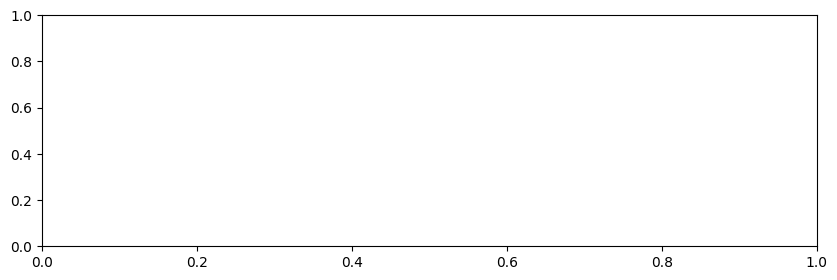

In [14]:
# bar plots

import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

data_0 = np.load("/Users/pavelpopov/mlp_nn/assets/introspection/mlp_on_new_ica/saliency/test_grads_0.npy")
data_1 = np.load("/Users/pavelpopov/mlp_nn/assets/introspection/mlp_on_new_ica/saliency/test_grads_1.npy")
x = np.arange(data_0.shape[2])
data_0 = data_0.reshape(-1, data_0.shape[2])
data_1 = data_1.reshape(-1, data_1.shape[2]) * -1.0

df_0 = pd.DataFrame(data_0, columns=[i for i in range(data_0.shape[1])])
df_0['Class'] = 0
df_1 = pd.DataFrame(data_1, columns=[i for i in range(data_1.shape[1])])
df_1['Class'] = 1
df = pd.concat([df_0, df_1], ignore_index=True)
df = pd.melt(df, id_vars=['Class'], var_name='Component', value_name='Saliency gradient')
# df
sns.boxplot(df, y="Saliency gradient", x="Component", hue="Class", ax=ax, palette=["blue", "red"], showfliers = False, linewidth=0.3)
# ax.grid(axis='x', linestyle='--', alpha=0.3, linewidth=0.3)
# # ax.invert_yaxis()
# ax.set_xticks(x, x, fontsize=6)
# # ax.set_ylim(-3, 55)
# ax.set_title("Gradients")


# fig.savefig(
#     f"barplots1.png",
#     format="png",
#     dpi=300,
#     bbox_inches="tight",
# )
# fig.savefig(
#     f"barplots1.svg",
#     format="svg",
#     bbox_inches="tight",
# )

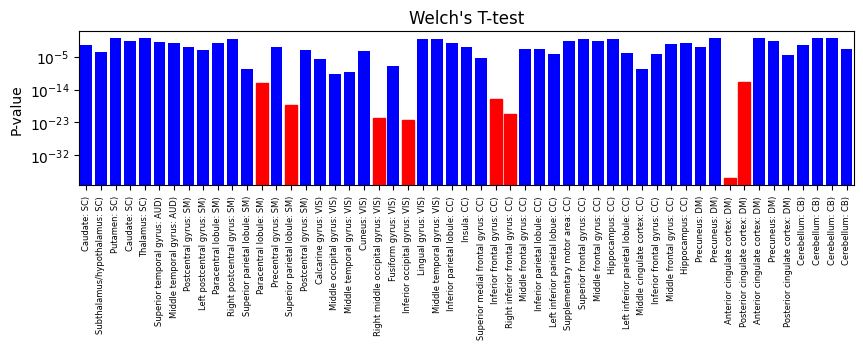

In [20]:
# bar plots

import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

data_0 = np.load("/Users/pavelpopov/mlp_nn/assets/introspection/mlp_on_new_ica/saliency/test_grads_0.npy")
data_1 = np.load("/Users/pavelpopov/mlp_nn/assets/introspection/mlp_on_new_ica/saliency/test_grads_1.npy")
x = np.arange(data_0.shape[2])
data_0 = data_0.reshape(-1, data_0.shape[2])
data_1 = data_1.reshape(-1, data_1.shape[2]) * -1.0

# # data has shape [observations, components]

# ttest_ind test
test = stats.ttest_ind(
    data_0, 
    data_1,
    # equal_var=False
)
pvals_ttest = test.pvalue
tvals_ttest = test.statistic

np.save("pvals.npy", pvals_ttest)
np.save("tvals.npy", tvals_ttest)

pvals_ttest = np.load("pvals.npy")
tvals_ttest = np.load("tvals.npy")

tests = ("Welch's T-test", pvals_ttest, tvals_ttest)

pvals = tests[1]
pvals = stats.false_discovery_control(pvals, method='by')
significant_p_vals = np.argwhere(pvals < 0.05)
# pvals = pvals / pvals.shape[0]

bars = ax.bar(
    x,
    pvals,
    align="center",
    color='blue',
)
ax.set_xticks(x, x, fontsize=6)
ax.set_ylabel("P-value")
ax.set_yscale("log")
ax.set_title(tests[0])
ax.set_xlim(-0.5, 52.5)


for i, bar in enumerate(bars):
    if pvals[i] < 1e-10:
        bar.set_color('red')
ax.set_xticks(x, [f"{neuromark[k][0]}: {neuromark[k][1].split('(')[1]}" for k in x], fontsize=6, rotation=90) #{a: (b, c, d, e, f) for a, b, c, d, e, f in zip(neuromark["Index"], neuromark["Name"], neuromark["Network"], neuromark["X"], neuromark["Y"], neuromark["Z"])}


fig.savefig(
    f"barplots2.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    f"barplots2.svg",
    format="svg",
    bbox_inches="tight",
)

In [ ]:
data_1 = np.random.standard_normal(50)
data_2 = np.random.standard_normal(50)

i = 10
while i < 1e10:
    data_1 = np.random.standard_normal((i, 50))
    # data_2 = np.random.standard_normal((i, 50))
    data_2 = 0.001 * np.ones((i, 50)) + np.random.standard_normal((i, 50))

    test = stats.ttest_ind(
        data_1, 
        data_2,
        # equal_var=False
    )
    pvals = test.pvalue
    
    pvals = stats.false_discovery_control(pvals, method='by')

    significant_p_vals = np.argwhere(pvals < 0.05)

    print(i)
    print(len(significant_p_vals))

    print()

    i *= 2

In [ ]:
tests = ["Mann-Whitney U rank test", "T-test","Kolmogorov-Smirnov test","Brunner-Munzel test"]

method = "saliency"
plots = {
    "cobre_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/fbirn_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/bsnip_spatial_fnc_"),
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip_spatial_fnc_"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test_spatial_fnc_"),
}

fig, ax = plt.subplots(3, 8, figsize=(24, 9))
ims = []
for index, (figure, paths) in enumerate(plots.items()):
    
    fbirn_grads_0 = np.load(f"{paths[0]}grads_0.npy")
    fbirn_grads_1 = np.load(f"{paths[0]}grads_1.npy")
    bsnip_grads_0 = np.load(f"{paths[1]}grads_0.npy")
    bsnip_grads_1 = np.load(f"{paths[1]}grads_1.npy")

    fbirn_pvals_ttest = []
    fbirn_tvals_ttest = []
    bsnip_pvals_ttest = []
    bsnip_tvals_ttest = []
    for i in range(fbirn_grads_0.shape[1]):
        fbirn_pvals_ttest.append([])
        fbirn_tvals_ttest.append([])
        bsnip_pvals_ttest.append([])
        bsnip_tvals_ttest.append([])
        for j in range(fbirn_grads_0.shape[1]):
            fbirn_test = stats.ttest_ind(
                fbirn_grads_0[:, i, j], 
                fbirn_grads_1[:, i, j],
                equal_var=False
            )
            bsnip_test = stats.ttest_ind(
                bsnip_grads_0[:, i, j], 
                bsnip_grads_1[:, i, j],
                equal_var=False
            )
            fbirn_pvals_ttest[-1].append(fbirn_test.pvalue)
            fbirn_tvals_ttest[-1].append(fbirn_test.statistic)
            bsnip_pvals_ttest[-1].append(bsnip_test.pvalue)
            bsnip_tvals_ttest[-1].append(bsnip_test.statistic)
        fbirn_pvals_ttest[-1] = np.array(fbirn_pvals_ttest[-1])
        fbirn_tvals_ttest[-1] = np.array(fbirn_tvals_ttest[-1])
        bsnip_pvals_ttest[-1] = np.array(bsnip_pvals_ttest[-1])
        bsnip_tvals_ttest[-1] = np.array(bsnip_tvals_ttest[-1])
    fbirn_pvals_ttest = np.array(fbirn_pvals_ttest)
    fbirn_tvals_ttest = np.array(fbirn_tvals_ttest)
    bsnip_pvals_ttest = np.array(bsnip_pvals_ttest)
    bsnip_tvals_ttest = np.array(bsnip_tvals_ttest)
    
    fbirn_pvals_ttest[np.diag_indices(fbirn_pvals_ttest.shape[0])] = 1
    fbirn_pvals_ttest[np.triu_indices_from(fbirn_pvals_ttest, k=1)] = stats.false_discovery_control(fbirn_pvals_ttest[np.triu_indices_from(fbirn_pvals_ttest, k=1)], method='by')
    pvals_triu = np.triu(fbirn_pvals_ttest, k=1)
    fbirn_pvals_ttest[np.tril_indices_from(fbirn_pvals_ttest, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]
    bsnip_pvals_ttest[np.diag_indices(bsnip_pvals_ttest.shape[0])] = 1
    bsnip_pvals_ttest[np.triu_indices_from(bsnip_pvals_ttest, k=1)] = stats.false_discovery_control(bsnip_pvals_ttest[np.triu_indices_from(bsnip_pvals_ttest, k=1)], method='by')
    pvals_triu = np.triu(bsnip_pvals_ttest, k=1)
    bsnip_pvals_ttest[np.tril_indices_from(bsnip_pvals_ttest, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]
    
    fbirn_mask = np.ones_like(fbirn_pvals_ttest)
    bsnip_mask = np.ones_like(bsnip_pvals_ttest)
    fbirn_mask[fbirn_pvals_ttest < 0.05] = 1
    bsnip_mask[bsnip_pvals_ttest < 0.05] = 1
    fbirn_mask[fbirn_pvals_ttest >= 0.05] = 0
    bsnip_mask[bsnip_pvals_ttest >= 0.05] = 0

    fbirn_grads_mean = np.mean(np.concatenate((fbirn_grads_0, fbirn_grads_1), axis=0), axis=0)
    bsnip_grads_mean = np.mean(np.concatenate((bsnip_grads_0, bsnip_grads_1), axis=0), axis=0)

    ims.append(ax[index][0].imshow(fbirn_grads_mean, cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][0].set_xticks([], [])
    ax[index][0].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][0].axis("off")
    ax[index][0].set_title(f"{figure} FBIRN corr mean", fontsize = 8)

    ims.append(ax[index][1].imshow(bsnip_grads_mean, cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][1].set_xticks([], [])
    ax[index][1].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][1].axis("off")
    ax[index][1].set_title(f"{figure} BSNIP corr mean", fontsize = 8)


    ims.append(ax[index][2].imshow(fbirn_pvals_ttest, cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][2].set_xticks([], [])
    ax[index][2].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][2].axis("off")
    ax[index][2].set_title(f"{figure} FBIRN P-vals", fontsize = 8)

    ims.append(ax[index][3].imshow(bsnip_pvals_ttest, cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][3].set_xticks([], [])
    ax[index][3].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][3].axis("off")
    ax[index][3].set_title(f"{figure} BSNIP P-vals", fontsize = 8)


    ims.append(ax[index][4].imshow(fbirn_mask, cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][4].set_xticks([], [])
    ax[index][4].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][4].axis("off")
    ax[index][4].set_title(f"{figure} FBIRN mask", fontsize = 8)

    ims.append(ax[index][5].imshow(bsnip_mask, cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][5].set_xticks([], [])
    ax[index][5].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][5].axis("off")
    ax[index][5].set_title(f"{figure} BSNIP mask", fontsize = 8)


    fbirn_filtered_max_val = np.max(np.abs(fbirn_tvals_ttest*fbirn_mask))
    ims.append(ax[index][6].imshow(fbirn_tvals_ttest*fbirn_mask, cmap="seismic"))
    ims[-1].set(clim=(-fbirn_filtered_max_val, fbirn_filtered_max_val))
    ax[index][6].set_xticks([], [])
    ax[index][6].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][6].axis("off")
    ax[index][6].set_title(f"{figure} FBIRN T-vals masked", fontsize = 8)

    bsnip_filtered_max_val = np.max(np.abs(bsnip_tvals_ttest*bsnip_mask))
    ims.append(ax[index][7].imshow(bsnip_tvals_ttest*bsnip_mask, cmap="seismic"))
    ims[-1].set(clim=(-bsnip_filtered_max_val, bsnip_filtered_max_val))
    ax[index][7].set_xticks([], [])
    ax[index][7].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][7].axis("off")
    ax[index][7].set_title(f"{figure} BSNIP T-vals maksed", fontsize = 8)


fig.savefig(f"test.png", dpi=300)

In [ ]:
# T-test Only
def compute_fnc(data):
    new_data = np.zeros((data.shape[0], data.shape[2], data.shape[2]))
    for i in range(new_data.shape[0]):
        new_data[i, :, :] = np.corrcoef(data[i, :, :], rowvar=False)
    
    return new_data

def run_ttest(data1, data2):
    pvals = []
    tvals = []
    for i in range(data1.shape[1]):
        pvals.append([])
        tvals.append([])
        for j in range(data1.shape[1]):
            test = stats.ttest_ind(
                data1[:, i, j], 
                data2[:, i, j],
                equal_var=False
            )
            pvals[-1].append(test.pvalue)
            tvals[-1].append(test.statistic)
        pvals[-1] = np.array(pvals[-1])
        tvals[-1] = np.array(tvals[-1])
    pvals = np.array(pvals)
    tvals = np.array(tvals)

    #run FDR correction
    pvals[np.diag_indices_from(pvals)] = 1
    pvals[np.triu_indices_from(pvals, k=1)] = stats.false_discovery_control(pvals[np.triu_indices_from(pvals, k=1)], method='by')
    pvals_triu = np.triu(pvals, k=1)
    pvals[np.tril_indices_from(pvals, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]

    #compute mask from pvals
    mask = np.ones_like(pvals)
    mask[pvals < 0.05] = 1
    mask[pvals >= 0.05] = 0

    return pvals, tvals, mask

method = "saliency"
plots = {
    "cobre_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/bsnip"),
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test"),
}

data_tested = "features"
# data_tested = "grads"

fig, ax = plt.subplots(3, 8, figsize=(24, 9))
ims = []
for index, (figure, paths) in enumerate(plots.items()):
    
    fbirn_grads_0 = np.load(f"{paths[0]}_grads_0.npy")
    fbirn_grads_1 = np.load(f"{paths[0]}_grads_1.npy")
    bsnip_grads_0 = np.load(f"{paths[1]}_grads_0.npy")
    bsnip_grads_1 = np.load(f"{paths[1]}_grads_1.npy")
    fbirn_features_0 = np.load(f"{paths[0]}_features_0.npy")
    fbirn_features_1 = np.load(f"{paths[0]}_features_1.npy")
    bsnip_features_0 = np.load(f"{paths[1]}_features_0.npy")
    bsnip_features_1 = np.load(f"{paths[1]}_features_1.npy")

    data = {
        "fbirn": {
            "raw_grads": (fbirn_grads_0, fbirn_grads_1),
            "raw_features":  (fbirn_features_0, fbirn_features_1)
        },
        "bsnip": {
            "raw_grads": (bsnip_grads_0, bsnip_grads_1),
            "raw_features":  (bsnip_features_0, bsnip_features_1)
        }
    }

    for dataset in data:
        data[dataset]["grads"] = (compute_fnc(data[dataset]["raw_grads"][0]), compute_fnc(data[dataset]["raw_grads"][1]))
        data[dataset]["features"] = (compute_fnc(data[dataset]["raw_features"][0]), compute_fnc(data[dataset]["raw_features"][1]))
        for data_type in ["grads", "features"]:
            pvals, tvals, mask = run_ttest(data[dataset][data_type][0], data[dataset][data_type][1])
            data[dataset][data_type+"_pvals"] = pvals
            data[dataset][data_type+"_tvals"] = tvals
            data[dataset][data_type+"_mask"] = mask

            data[dataset][data_type+"_mean"] = np.mean(np.concatenate((data[dataset][data_type][0], data[dataset][data_type][0]), axis=0), axis=0)
    
    print(figure + "data shape")
    for dataset in data:
        for key in data[dataset]:
            if key in ["raw_grads", "raw_features", "grads", "features"]:
                print(f"{dataset} {key}: {data[dataset][key][0].shape}, {data[dataset][key][1].shape}")
            else:
                print(f"{dataset} {key}: {data[dataset][key].shape}")
    print()

    ims.append(ax[index][0].imshow(data["fbirn"][data_tested+"_mean"], cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][0].set_xticks([], [])
    ax[index][0].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][0].axis("off")
    ax[index][0].set_title(f"{figure} FBIRN corr mean", fontsize = 8)

    ims.append(ax[index][1].imshow(data["bsnip"][data_tested+"_mean"], cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][1].set_xticks([], [])
    ax[index][1].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][1].axis("off")
    ax[index][1].set_title(f"{figure} BSNIP corr mean", fontsize = 8)


    ims.append(ax[index][2].imshow(data["fbirn"][data_tested+"_pvals"], cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][2].set_xticks([], [])
    ax[index][2].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][2].axis("off")
    ax[index][2].set_title(f"{figure} FBIRN P-vals", fontsize = 8)

    ims.append(ax[index][3].imshow(data["bsnip"][data_tested+"_pvals"], cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][3].set_xticks([], [])
    ax[index][3].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][3].axis("off")
    ax[index][3].set_title(f"{figure} BSNIP P-vals", fontsize = 8)


    ims.append(ax[index][4].imshow(data["fbirn"][data_tested+"_mask"], cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][4].set_xticks([], [])
    ax[index][4].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][4].axis("off")
    ax[index][4].set_title(f"{figure} FBIRN mask", fontsize = 8)

    ims.append(ax[index][5].imshow(data["bsnip"][data_tested+"_mask"], cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][5].set_xticks([], [])
    ax[index][5].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][5].axis("off")
    ax[index][5].set_title(f"{figure} BSNIP mask", fontsize = 8)


    fbirn_filtered_max_val = np.max(np.abs(data["fbirn"][data_tested+"_tvals"]*data["fbirn"][data_tested+"_mask"]))
    ims.append(ax[index][6].imshow(data["fbirn"][data_tested+"_tvals"]*data["fbirn"][data_tested+"_mask"], cmap="seismic"))
    ims[-1].set(clim=(-fbirn_filtered_max_val, fbirn_filtered_max_val))
    ax[index][6].set_xticks([], [])
    ax[index][6].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][6].axis("off")
    ax[index][6].set_title(f"{figure} FBIRN T-vals masked", fontsize = 8)

    bsnip_filtered_max_val = np.max(np.abs(data["bsnip"][data_tested+"_tvals"]*data["bsnip"][data_tested+"_mask"]))
    ims.append(ax[index][7].imshow(data["bsnip"][data_tested+"_tvals"]*data["bsnip"][data_tested+"_mask"], cmap="seismic"))
    ims[-1].set(clim=(-bsnip_filtered_max_val, bsnip_filtered_max_val))
    ax[index][7].set_xticks([], [])
    ax[index][7].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][7].axis("off")
    ax[index][7].set_title(f"{figure} BSNIP T-vals maksed", fontsize = 8)


fig.savefig(f"test_{data_tested}.png", dpi=300)

In [ ]:
# T-test maksing experiments
def compute_fnc(data):
    new_data = np.zeros((data.shape[0], data.shape[2], data.shape[2]))
    for i in range(new_data.shape[0]):
        new_data[i, :, :] = np.corrcoef(data[i, :, :], rowvar=False)
    
    return new_data

def run_ttest(data1, data2):
    pvals = []
    tvals = []
    for i in range(data1.shape[1]):
        pvals.append([])
        tvals.append([])
        for j in range(data1.shape[1]):
            test = stats.ttest_ind(
                data1[:, i, j], 
                data2[:, i, j],
                equal_var=False
            )
            pvals[-1].append(test.pvalue)
            tvals[-1].append(test.statistic)
        pvals[-1] = np.array(pvals[-1])
        tvals[-1] = np.array(tvals[-1])
    pvals = np.array(pvals)
    tvals = np.array(tvals)

    #run FDR correction
    pvals[np.diag_indices_from(pvals)] = 1
    pvals[np.triu_indices_from(pvals, k=1)] = stats.false_discovery_control(pvals[np.triu_indices_from(pvals, k=1)], method='by')
    pvals_triu = np.triu(pvals, k=1)
    pvals[np.tril_indices_from(pvals, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]

    #compute mask from pvals
    mask = np.ones_like(pvals)
    mask[pvals < 0.05] = 1
    mask[pvals >= 0.05] = 0

    return pvals, tvals, mask

method = "saliency"
plots = {
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test"),
}

data_tested = "grads"

fig, ax = plt.subplots(2, 7, figsize=(18, 6))
ims = []
for index, (figure, paths) in enumerate(plots.items()):
    
    fbirn_grads_0 = np.load(f"{paths[0]}_grads_0.npy")
    fbirn_grads_1 = np.load(f"{paths[0]}_grads_1.npy")
    bsnip_grads_0 = np.load(f"{paths[1]}_grads_0.npy")
    bsnip_grads_1 = np.load(f"{paths[1]}_grads_1.npy")

    data = {
        "fbirn": {
            "raw_grads": (fbirn_grads_0, fbirn_grads_1),
        },
        "bsnip": {
            "raw_grads": (bsnip_grads_0, bsnip_grads_1),
        }
    }

    for dataset in data:
        data[dataset]["grads"] = (compute_fnc(data[dataset]["raw_grads"][0]), compute_fnc(data[dataset]["raw_grads"][1]))
        for data_type in ["grads"]:
            pvals, tvals, mask = run_ttest(data[dataset][data_type][0], data[dataset][data_type][1])
            data[dataset][data_type+"_pvals"] = pvals
            data[dataset][data_type+"_tvals"] = tvals
            data[dataset][data_type+"_mask"] = mask

            data[dataset][data_type+"_mean"] = np.mean(np.concatenate((data[dataset][data_type][0], data[dataset][data_type][0]), axis=0), axis=0)
    
    primary_dataset = "fbirn" if "fbirn" in figure else "bsnip"
    secondary_dataset = "fbirn" if primary_dataset == "bsnip" else "bsnip"

    primary_mask = data[primary_dataset][data_type+"_mask"]
    secondary_mask = data[secondary_dataset][data_type+"_mask"]

    plot_index = 0

    ims.append(ax[index][plot_index].imshow(primary_mask, cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"{figure} {primary_dataset} mask", fontsize = 6)
    plot_index += 1

    ims.append(ax[index][plot_index].imshow(secondary_mask, cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4) 
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"{figure} {secondary_dataset} mask", fontsize = 6)
    plot_index += 1

    plot_data = data[primary_dataset][data_tested+"_tvals"] * data[primary_dataset][data_type+"_mask"] 
    data_max = np.max(np.abs(plot_data))
    ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
    ims[-1].set(clim=(-data_max, data_max))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4) 
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"{primary_dataset} T-vals x {primary_dataset} mask", fontsize = 6)
    plot_index += 1

    plot_data = data[secondary_dataset][data_tested+"_tvals"] * data[secondary_dataset][data_type+"_mask"] 
    data_max = np.max(np.abs(plot_data))
    ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
    ims[-1].set(clim=(-data_max, data_max))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"{secondary_dataset} T-vals x {secondary_dataset} mask", fontsize = 6)
    plot_index += 1

    plot_data = np.logical_and(data[primary_dataset][data_type+"_mask"], data[secondary_dataset][data_type+"_mask"])
    data_max = np.max(np.abs(plot_data))
    ims.append(ax[index][plot_index].imshow(plot_data, cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"AND({primary_dataset} mask, {secondary_dataset} mask)", fontsize = 6)
    plot_index += 1

    plot_data = np.logical_and(np.logical_not(data[primary_dataset][data_type+"_mask"]), data[secondary_dataset][data_type+"_mask"])
    data_max = np.max(np.abs(plot_data))
    ims.append(ax[index][plot_index].imshow(plot_data, cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"AND(NOT({primary_dataset} mask), {secondary_dataset} mask)", fontsize = 6)
    plot_index += 1

    plot_data_and = data[secondary_dataset][data_tested+"_tvals"] * np.logical_and(data[primary_dataset][data_type+"_mask"], data[secondary_dataset][data_type+"_mask"])
    plot_data_andnot = data[secondary_dataset][data_tested+"_tvals"] * np.logical_and(np.logical_not(data[primary_dataset][data_type+"_mask"]), data[secondary_dataset][data_type+"_mask"])
    plot_data = np.tril(plot_data_and) + np.triu(plot_data_andnot)
    data_max = np.max(np.abs(plot_data))
    ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
    ims[-1].set(clim=(-data_max, data_max))
    ax[index][plot_index].set_xticks([], [])
    ax[index][plot_index].set_yticks([], [])
    fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
    ax[index][plot_index].axis("off")
    ax[index][plot_index].set_title(f"TRI_L: {secondary_dataset} T-vals x AND({primary_dataset} mask, {secondary_dataset} mask)\n TRI_U: {secondary_dataset} T-vals x AND(NOT({primary_dataset} mask), {secondary_dataset} mask)", fontsize = 6)
    plot_index += 1

    # plot_data = data[secondary_dataset][data_tested+"_tvals"] * np.logical_and(np.logical_not(data[primary_dataset][data_type+"_mask"]), data[secondary_dataset][data_type+"_mask"])
    # data_max = np.max(np.abs(plot_data))
    # ims.append(ax[index][plot_index].imshow(plot_data, cmap="seismic"))
    # ims[-1].set(clim=(-data_max, data_max))
    # ax[index][plot_index].set_xticks([], [])
    # ax[index][plot_index].set_yticks([], [])
    # fig.colorbar(ims[-1],fraction=0.046, pad=0.04).ax.tick_params(labelsize=4)
    # ax[index][plot_index].axis("off")
    # ax[index][plot_index].set_title(f"{secondary_dataset} T-vals x AND(NOT({primary_dataset} mask), {secondary_dataset} mask)", fontsize = 6)
    # plot_index += 1

fig.savefig(f"test_masks.png", dpi=300, bbox_inches='tight')

In [ ]:
def compute_fnc(data):
    new_data = np.zeros((data.shape[0], data.shape[2], data.shape[2]))
    for i in range(new_data.shape[0]):
        new_data[i, :, :] = np.corrcoef(data[i, :, :], rowvar=False)
    
    return new_data

def run_ttest(data1, data2):
    pvals = []
    tvals = []
    for i in range(data1.shape[1]):
        pvals.append([])
        tvals.append([])
        for j in range(data1.shape[1]):
            test = stats.ttest_ind(
                data1[:, i, j], 
                data2[:, i, j],
                equal_var=False
            )
            pvals[-1].append(test.pvalue)
            tvals[-1].append(test.statistic)
        pvals[-1] = np.array(pvals[-1])
        tvals[-1] = np.array(tvals[-1])
    pvals = np.array(pvals)
    tvals = np.array(tvals)

    #run FDR correction
    pvals[np.diag_indices_from(pvals)] = 1
    pvals[np.triu_indices_from(pvals, k=1)] = stats.false_discovery_control(pvals[np.triu_indices_from(pvals, k=1)], method='by')
    pvals_triu = np.triu(pvals, k=1)
    pvals[np.tril_indices_from(pvals, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]

    #compute mask from pvals
    mask = np.ones_like(pvals)
    mask[pvals < 0.05] = 1
    mask[pvals >= 0.05] = 0

    return pvals, tvals, mask

method = "saliency"
plots = {
    "cobre_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/bsnip"),
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test"),
}

data_tested = "features"
# data_tested = "grads"

fig, ax = plt.subplots(3, 8, figsize=(24, 9))
ims = []
for index, (figure, paths) in enumerate(plots.items()):
    
    fbirn_grads_0 = np.load(f"{paths[0]}_grads_0.npy")
    fbirn_grads_1 = np.load(f"{paths[0]}_grads_1.npy")
    bsnip_grads_0 = np.load(f"{paths[1]}_grads_0.npy")
    bsnip_grads_1 = np.load(f"{paths[1]}_grads_1.npy")
    fbirn_features_0 = np.load(f"{paths[0]}_features_0.npy")
    fbirn_features_1 = np.load(f"{paths[0]}_features_1.npy")
    bsnip_features_0 = np.load(f"{paths[1]}_features_0.npy")
    bsnip_features_1 = np.load(f"{paths[1]}_features_1.npy")

    data = {
        "fbirn": {
            "raw_grads": (fbirn_grads_0, fbirn_grads_1),
            "raw_features":  (fbirn_features_0, fbirn_features_1)
        },
        "bsnip": {
            "raw_grads": (bsnip_grads_0, bsnip_grads_1),
            "raw_features":  (bsnip_features_0, bsnip_features_1)
        }
    }

    for dataset in data:
        data[dataset]["grads"] = (compute_fnc(data[dataset]["raw_grads"][0]), compute_fnc(data[dataset]["raw_grads"][1]))
        data[dataset]["features"] = (compute_fnc(data[dataset]["raw_features"][0]), compute_fnc(data[dataset]["raw_features"][1]))
        for data_type in ["grads", "features"]:
            pvals, tvals, mask = run_ttest(data[dataset][data_type][0], data[dataset][data_type][1])
            data[dataset][data_type+"_pvals"] = pvals
            data[dataset][data_type+"_tvals"] = tvals
            data[dataset][data_type+"_mask"] = mask

            data[dataset][data_type+"_mean"] = np.mean(np.concatenate((data[dataset][data_type][0], data[dataset][data_type][0]), axis=0), axis=0)
    
    print(figure + "data shape")
    for dataset in data:
        for key in data[dataset]:
            if key in ["raw_grads", "raw_features", "grads", "features"]:
                print(f"{dataset} {key}: {data[dataset][key][0].shape}, {data[dataset][key][1].shape}")
            else:
                print(f"{dataset} {key}: {data[dataset][key].shape}")
    print()

    ims.append(ax[index][0].imshow(data["fbirn"][data_tested+"_mean"], cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][0].set_xticks([], [])
    ax[index][0].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][0].axis("off")
    ax[index][0].set_title(f"{figure} FBIRN corr mean", fontsize = 8)

    ims.append(ax[index][1].imshow(data["bsnip"][data_tested+"_mean"], cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][1].set_xticks([], [])
    ax[index][1].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][1].axis("off")
    ax[index][1].set_title(f"{figure} BSNIP corr mean", fontsize = 8)


    ims.append(ax[index][2].imshow(data["fbirn"][data_tested+"_pvals"], cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][2].set_xticks([], [])
    ax[index][2].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][2].axis("off")
    ax[index][2].set_title(f"{figure} FBIRN P-vals", fontsize = 8)

    ims.append(ax[index][3].imshow(data["bsnip"][data_tested+"_pvals"], cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][3].set_xticks([], [])
    ax[index][3].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][3].axis("off")
    ax[index][3].set_title(f"{figure} BSNIP P-vals", fontsize = 8)


    ims.append(ax[index][4].imshow(data["fbirn"][data_tested+"_mask"], cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][4].set_xticks([], [])
    ax[index][4].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][4].axis("off")
    ax[index][4].set_title(f"{figure} FBIRN mask", fontsize = 8)

    ims.append(ax[index][5].imshow(data["bsnip"][data_tested+"_mask"], cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][5].set_xticks([], [])
    ax[index][5].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][5].axis("off")
    ax[index][5].set_title(f"{figure} BSNIP mask", fontsize = 8)


    fbirn_filtered_max_val = np.max(np.abs(data["fbirn"][data_tested+"_tvals"]*data["fbirn"][data_tested+"_mask"]))
    ims.append(ax[index][6].imshow(data["fbirn"][data_tested+"_tvals"]*data["fbirn"][data_tested+"_mask"], cmap="seismic"))
    ims[-1].set(clim=(-fbirn_filtered_max_val, fbirn_filtered_max_val))
    ax[index][6].set_xticks([], [])
    ax[index][6].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][6].axis("off")
    ax[index][6].set_title(f"{figure} FBIRN T-vals masked", fontsize = 8)

    bsnip_filtered_max_val = np.max(np.abs(data["bsnip"][data_tested+"_tvals"]*data["bsnip"][data_tested+"_mask"]))
    ims.append(ax[index][7].imshow(data["bsnip"][data_tested+"_tvals"]*data["bsnip"][data_tested+"_mask"], cmap="seismic"))
    ims[-1].set(clim=(-bsnip_filtered_max_val, bsnip_filtered_max_val))
    ax[index][7].set_xticks([], [])
    ax[index][7].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][7].axis("off")
    ax[index][7].set_title(f"{figure} BSNIP T-vals maksed", fontsize = 8)


fig.savefig(f"test_{data_tested}.png", dpi=300)

In [ ]:
from src.datasets.fbirn import load_data as load_data_fbirn
from src.datasets.bsnip import load_data as load_data_bsnip
from omegaconf import DictConfig

method = "saliency"
plots = {
    "cobre_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/bsnip"),
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test"),
}

data_tested = "features"
# data_tested = "grads"

fig, ax = plt.subplots(1, 8, figsize=(24, 3))
ims = []
for index in range(1):
    
    figure = "Loaded features"
    cfg = DictConfig({"dataset": {"filter_indices": True}})
    fbirn_features, fbirn_labels = load_data_fbirn(cfg)
    bsnip_features, bsnip_labels = load_data_bsnip(cfg)


    fbirn_features_0 = fbirn_features[fbirn_labels == 0]
    fbirn_features_1 = fbirn_features[fbirn_labels == 1]
    bsnip_features_0 = bsnip_features[bsnip_labels == 0]
    bsnip_features_1 = bsnip_features[bsnip_labels == 1]

    data = {
        "fbirn": {
            # "raw_grads": (fbirn_grads_0, fbirn_grads_1),
            "raw_features":  (fbirn_features_0, fbirn_features_1)
        },
        "bsnip": {
            # "raw_grads": (bsnip_grads_0, bsnip_grads_1),
            "raw_features":  (bsnip_features_0, bsnip_features_1)
        }
    }

    for dataset in data:
        # data[dataset]["grads"] = (compute_fnc(data[dataset]["raw_grads"][0]), compute_fnc(data[dataset]["raw_grads"][1]))
        data[dataset]["features"] = (compute_fnc(data[dataset]["raw_features"][0]), compute_fnc(data[dataset]["raw_features"][1]))
        for data_type in ["features"]:
            pvals, tvals, mask = run_ttest(data[dataset][data_type][0], data[dataset][data_type][1])
            data[dataset][data_type+"_pvals"] = pvals
            data[dataset][data_type+"_tvals"] = tvals
            data[dataset][data_type+"_mask"] = mask

            data[dataset][data_type+"_mean"] = np.mean(np.concatenate((data[dataset][data_type][0], data[dataset][data_type][0]), axis=0), axis=0)
    
    print(figure + "data shape")
    for dataset in data:
        for key in data[dataset]:
            if key in ["raw_grads", "raw_features", "grads", "features"]:
                print(f"{dataset} {key}: {data[dataset][key][0].shape}, {data[dataset][key][1].shape}")
            else:
                print(f"{dataset} {key}: {data[dataset][key].shape}")
    print()

    ax = [ax]
    ims.append(ax[index][0].imshow(data["fbirn"][data_tested+"_mean"], cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][0].set_xticks([], [])
    ax[index][0].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][0].axis("off")
    ax[index][0].set_title(f"{figure} FBIRN corr mean", fontsize = 8)

    ims.append(ax[index][1].imshow(data["bsnip"][data_tested+"_mean"], cmap="seismic"))
    ims[-1].set(clim=(-1.0, 1.0))
    ax[index][1].set_xticks([], [])
    ax[index][1].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][1].axis("off")
    ax[index][1].set_title(f"{figure} BSNIP corr mean", fontsize = 8)


    ims.append(ax[index][2].imshow(data["fbirn"][data_tested+"_pvals"], cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][2].set_xticks([], [])
    ax[index][2].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][2].axis("off")
    ax[index][2].set_title(f"{figure} FBIRN P-vals", fontsize = 8)

    ims.append(ax[index][3].imshow(data["bsnip"][data_tested+"_pvals"], cmap="inferno"))
    ims[-1].set(clim=(0, 0.05))
    ax[index][3].set_xticks([], [])
    ax[index][3].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][3].axis("off")
    ax[index][3].set_title(f"{figure} BSNIP P-vals", fontsize = 8)


    ims.append(ax[index][4].imshow(data["fbirn"][data_tested+"_mask"], cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][4].set_xticks([], [])
    ax[index][4].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][4].axis("off")
    ax[index][4].set_title(f"{figure} FBIRN mask", fontsize = 8)

    ims.append(ax[index][5].imshow(data["bsnip"][data_tested+"_mask"], cmap="inferno"))
    ims[-1].set(clim=(0, 1))
    ax[index][5].set_xticks([], [])
    ax[index][5].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][5].axis("off")
    ax[index][5].set_title(f"{figure} BSNIP mask", fontsize = 8)


    fbirn_filtered_max_val = np.max(np.abs(data["fbirn"][data_tested+"_tvals"]*data["fbirn"][data_tested+"_mask"]))
    ims.append(ax[index][6].imshow(data["fbirn"][data_tested+"_tvals"]*data["fbirn"][data_tested+"_mask"], cmap="seismic"))
    ims[-1].set(clim=(-fbirn_filtered_max_val, fbirn_filtered_max_val))
    ax[index][6].set_xticks([], [])
    ax[index][6].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][6].axis("off")
    ax[index][6].set_title(f"{figure} FBIRN T-vals masked", fontsize = 8)

    bsnip_filtered_max_val = np.max(np.abs(data["bsnip"][data_tested+"_tvals"]*data["bsnip"][data_tested+"_mask"]))
    ims.append(ax[index][7].imshow(data["bsnip"][data_tested+"_tvals"]*data["bsnip"][data_tested+"_mask"], cmap="seismic"))
    ims[-1].set(clim=(-bsnip_filtered_max_val, bsnip_filtered_max_val))
    ax[index][7].set_xticks([], [])
    ax[index][7].set_yticks([], [])
    fig.colorbar(ims[-1])
    ax[index][7].axis("off")
    ax[index][7].set_title(f"{figure} BSNIP T-vals maksed", fontsize = 8)


fig.savefig(f"test_loaded_features.png", dpi=300)

In [ ]:
tests = ["Mann-Whitney U rank test", "T-test","Kolmogorov-Smirnov test","Brunner-Munzel test"]

method = "ignt"
plots = {
    "cobre_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/fbirn_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/bsnip_spatial_fnc_"),
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip_spatial_fnc_"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test_spatial_fnc_"),
}

for figure, paths in plots.items():
    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    ims = []

    for i, test in enumerate(tests):
        fbirn = np.load(f"{paths[0]}{test}.npy")
        bsnip = np.load(f"{paths[1]}{test}.npy")

        fbirn[fbirn > 0.05] = 1
        bsnip[bsnip > 0.05] = 1

        ims.append(ax[i][0].imshow(fbirn, cmap="seismic"))
        ims[-1].set(clim=(-0.05, 0.05))
        ax[i][0].set_xticks([], [])
        ax[i][0].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][0].axis("off")
        ax[i][0].set_title(f"{test} FBIRN")
        
        ims.append(ax[i][1].imshow(bsnip, cmap="seismic"))
        ims[-1].set(clim=(-0.05, 0.05))
        ax[i][1].set_xticks([], [])
        ax[i][1].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][1].axis("off")
        ax[i][1].set_title(f"{test} BSNIP")

        # fbirn[fbirn > 0.99] = 0
        # bsnip[bsnip > 0.99] = 0

        ims.append(ax[i][2].imshow(fbirn-bsnip, cmap="seismic"))
        ims[-1].set(clim=(-0.05, 0.05))
        ax[i][2].set_xticks([], [])
        ax[i][2].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][2].axis("off")
        ax[i][2].set_title(f"{test} diff")

    fig.savefig(f"{figure}.png", dpi=300)

In [ ]:
tests = ["Mann-Whitney U rank test", "T-test","Kolmogorov-Smirnov test","Brunner-Munzel test"]

method = "saliency"
plots = {
    "fbirn": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn_spatial_fnc_"),
    "bsnip": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip_spatial_fnc_"),
}

for figure, paths in plots.items():
    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    ims = []

    for i, test in enumerate(tests):
        orig = np.load(f"{paths[0]}{test}.npy")
        transfer = np.load(f"{paths[1]}{test}.npy")

        orig[orig > 0.05] = 1
        transfer[transfer > 0.05] = 1

        ims.append(ax[i][0].imshow(orig, cmap="seismic"))
        ims[-1].set(clim=(-0.05, 0.05))
        ax[i][0].set_xticks([], [])
        ax[i][0].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][0].axis("off")
        ax[i][0].set_title(f"{test} {figure} Orig")
        
        ims.append(ax[i][1].imshow(transfer, cmap="seismic"))
        ims[-1].set(clim=(-0.05, 0.05))
        ax[i][1].set_xticks([], [])
        ax[i][1].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][1].axis("off")
        ax[i][1].set_title(f"{test} {figure} Transfer")

        # orig[orig > 0.99] = 0
        # transfer[transfer > 0.99] = 0

        ims.append(ax[i][2].imshow(orig-transfer, cmap="seismic"))
        ims[-1].set(clim=(-0.05, 0.05))
        ax[i][2].set_xticks([], [])
        ax[i][2].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][2].axis("off")
        ax[i][2].set_title(f"{test} diff")

    fig.savefig(f"{figure}.png", dpi=300)

In [ ]:
tests = ["Mann-Whitney U rank test", "T-test","Kolmogorov-Smirnov test","Brunner-Munzel test"]

method = "saliency"
plots = {
    "cobre_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/fbirn_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-cobre/{method}/bsnip_spatial_fnc_"),
    "fbirn_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/test_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-fbirn/{method}/bsnip_spatial_fnc_"),
    "bsnip_trained": (f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/fbirn_spatial_fnc_", f"./assets/introspection/rerun_all2-exp-rearranged_mlp_defHP-bsnip/{method}/test_spatial_fnc_"),
}

for figure, paths in plots.items():
    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    ims = []

    for i, test in enumerate(tests):
        fbirn = np.load(f"{paths[0]}{test}.npy")
        bsnip = np.load(f"{paths[1]}{test}.npy")

        fbirn = np.log(0.05 / fbirn)
        bsnip = np.log(0.05 / bsnip)
        fbirn[fbirn < 0] = 0
        bsnip[bsnip < 0] = 0
        fbirn /= np.max(fbirn)
        bsnip /= np.max(bsnip)

        ims.append(ax[i][0].imshow(fbirn, cmap="inferno"))
        # ims[-1].set(clim=(-0.05, 0.05))
        ax[i][0].set_xticks([], [])
        ax[i][0].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][0].axis("off")
        ax[i][0].set_title(f"{test} FBIRN")
        
        ims.append(ax[i][1].imshow(bsnip, cmap="inferno"))
        # ims[-1].set(clim=(-0.05, 0.05))
        ax[i][1].set_xticks([], [])
        ax[i][1].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][1].axis("off")
        ax[i][1].set_title(f"{test} BSNIP")

        # fbirn[fbirn > 0.99] = 0
        # bsnip[bsnip > 0.99] = 0

        diff = fbirn-bsnip
        max_abs_diff = np.max(np.abs(diff))
        ims.append(ax[i][2].imshow(diff, cmap="seismic"))
        ims[-1].set(clim=(-max_abs_diff, max_abs_diff))
        ax[i][2].set_xticks([], [])
        ax[i][2].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[i][2].axis("off")
        ax[i][2].set_title(f"{test} diff")

    fig.savefig(f"{figure}.png", dpi=300)

In [ ]:
class Introspector:
    """Basic introspector"""

    def __init__(self, model, features, labels, methods, save_path) -> None:
        self.methods = methods
        self.save_path = save_path
        self.model = model

        self.features = features
        self.labels = labels

        # os.makedirs(f"{self.save_path}timeseries", exist_ok=True)
        if "saliency" in self.methods:
            # os.makedirs(f"{self.save_path}saliency/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}saliency/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}saliency", exist_ok=True)
        if "ig" in self.methods:
            # os.makedirs(f"{self.save_path}ig/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}ig/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}ig", exist_ok=True)
        if "ignt" in self.methods:
            # os.makedirs(f"{self.save_path}ignt/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}ignt/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}ignt", exist_ok=True)

    def run(self, cutoff=1, percentile=0.1):
        """Run introspection, save results"""
        targets = torch.unique(self.labels)
        n_classes = targets.shape[0]

        print(f"Getting MLP predictions for {self.save_path}")
        features, timeseries, smooth_timeseries, predictions = (
            [None]*n_classes, 
            [None]*n_classes, 
            [None]*n_classes, 
            [None]*n_classes,
        )

        window_size = 10
        for class_idx in range(n_classes):
            filter_array = self.labels == class_idx
            features[class_idx] = self.features[filter_array]
            features[class_idx].requires_grad = False

            timeseries_raw, predictions[class_idx] = self.model(features[class_idx], introspection=True)
            timeseries_raw = timeseries_raw.cpu().detach().numpy()
            predictions[class_idx] = predictions[class_idx].cpu().detach().numpy()
            
            # timeseries_raw was calculated for the data related to class_idx;
            # yet it has `n_classes` class prediction time series in 3rd dimension
            # so timeseries[class_idx] is a list of length n_classes, each element of which
            # represents the class prediction time series
            timeseries[class_idx] = [timeseries_raw[:, :, j] for j in range(n_classes)]

            smooth_timeseries[class_idx] = deepcopy(timeseries[class_idx])
            for j in range(n_classes):
                for subject in range(smooth_timeseries[class_idx][j].shape[0]):
                    smooth_timeseries[class_idx][j][subject] = np.convolve(smooth_timeseries[class_idx][j][subject], np.ones(window_size)/window_size, mode='same')

        # all_features = torch.concat(features)
        # features = [all_features, all_features]

        grads = {key: None for key in self.methods}
        specific_grads = {key: None for key in self.methods}
        for method in self.methods:
            print(f"Processing {method}")

            sizes = [features[j].shape for j in range(n_classes)]
            # print(features[0].shape)
            # print(features[0].reshape(-1, 1, 53).shape)
            # grads[method] = [self.get_grads(method, features[j].reshape(-1, 1, 53), j).cpu().detach().numpy().reshape(*sizes[j]) for j in range(n_classes)]
            grads[method] = [self.get_grads(method, features[j], j).cpu().detach().numpy() for j in range(n_classes)]
            print(grads[method][0].shape)

            np.save(f"{self.save_path}{method}/grads_0.npy", grads[method][0])
            np.save(f"{self.save_path}{method}/grads_1.npy", grads[method][1])

            specific_grads[method] = []
            for i in range(n_classes):
                if i == 0:
                    filter_array = np.argwhere(timeseries[i][0] > timeseries[i][1])
                else:
                    filter_array = np.argwhere(timeseries[i][0] < timeseries[i][1])
                
                specific_grads[method].append(np.array([grads[method][i][x, y, :] for (x, y) in filter_array]))

            # print(specific_grads[method][0].shape)
            # print(grads[method][0].shape)
            np.save(f"{self.save_path}{method}/filtered_grads_0.npy", specific_grads[method][0])
            np.save(f"{self.save_path}{method}/filtered_grads_1.npy", specific_grads[method][1])

        # plot everything
        for method in self.methods:
            print(f"Plotting {method}")

            # for i in range(n_classes):
            #     print(f"Plotting time series for true target {i}")
            #     self.plot_timeseries(
            #         timeseries=timeseries[i], 
            #         smooth_timeseries=smooth_timeseries[i], 
            #         grads=grads[method][i],
            #         features=features[i],
            #         predictions=predictions[i],
            #         target=i,
            #         cutoff=cutoff, 
            #         filepath=f"{self.save_path}{method}/timeseries_target_{i}"
            #     )

            print(f"Plotting spatial attention")
            self.plot_histograms(
                grads=grads[method],
                # grads=specific_grads[method],
                features=features,
                cutoff=cutoff, 
                filepath=f"{self.save_path}{method}/spatial",
                method=method,
                percentile=percentile
            )



    def plot_timeseries(self, timeseries, smooth_timeseries, grads, features, predictions, target, filepath, cutoff, use_log=False):
        fig, ax = plt.subplots(2, cutoff,figsize=(3*cutoff, 4))

        x = np.arange(timeseries[0].shape[1])
        for i in range(cutoff):
            smooth_line_0 = ax[0][i].plot(x[:140], smooth_timeseries[0][i][:140], label='0', color='blue')
            smooth_line_1 = ax[0][i].plot(x[:140], smooth_timeseries[1][i][:140], label='1', color='red')
            line_0 = ax[0][i].plot(x[:140], timeseries[0][i][:140], '#00009922')
            line_1 = ax[0][i].plot(x[:140], timeseries[1][i][:140], '#99000022')

            # ax[i].set_title(f"True target = {target}, Predicted target = {predictions[i]}")
            ax[0][i].legend(title="Prediction")
            
            ax[0][i].set_xlim(0, 140)
            ax[0][i].set_xticklabels([])
            ax[0][i].set_xticks([])
            ax[0][i].set_yticklabels([])
            ax[0][i].set_yticks([])
            ax[0][i].set_xlabel("Time")
            ax[0][i].set_ylabel("Prediction strength" if i == 0 else "")

            # grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            feat = features[i].cpu().detach().numpy()[np.newaxis, :, :]
            _, _ = viz.visualize_image_attr(
                np.transpose(grad, (2, 1, 0))[:,:140, :],
                np.transpose(feat, (2, 1, 0))[:,:140, :],
                method="heat_map",
                cmap="inferno",
                show_colorbar=False,
                plt_fig_axis=(fig, ax[1][i]),
                use_pyplot=False,
            )
            ax[0][i].grid()

        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )

        
    def plot_histograms(self, grads, features, cutoff, filepath, method, percentile=0.1):
        sns.reset_defaults()

        data_0 = grads[0]
        data_1 = grads[1]

        corr_0 = np.corrcoef(grads[0].reshape(-1, grads[0].shape[2]).T)
        corr_1 = np.corrcoef(grads[1].reshape(-1, grads[1].shape[2]).T)
        difcor = np.abs(corr_0-corr_1)

        print("raw data shape")
        print(data_0.shape)

        pearson_0 = np.zeros((data_0.shape[0], data_0.shape[2], data_0.shape[2]))
        pearson_1 = np.zeros((data_1.shape[0], data_1.shape[2], data_1.shape[2]))
        for i in range(pearson_0.shape[0]):
            pearson_0[i, :, :] = np.corrcoef(data_0[i, :, :], rowvar=False)
        for i in range(pearson_1.shape[0]):
            pearson_1[i, :, :] = np.corrcoef(data_1[i, :, :], rowvar=False)

        # print("pearson_0 shape")
        # print(pearson_0.shape)
        # print("pearson_1 shape")
        # print(pearson_1.shape)
        
        # mannwhitney U rank test
        pvals_mw = []
        for i in range(pearson_0.shape[1]):
            pvals_mw.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.mannwhitneyu(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                )
                    
                pvals_mw[-1].append(test.pvalue)

            pvals_mw[-1] = np.array(pvals_mw[-1])
        pvals_mw = np.array(pvals_mw)

        # ttest_ind test
        pvals_ttest = []
        for i in range(pearson_0.shape[1]):
            pvals_ttest.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.ttest_ind(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                    equal_var=False
                )
                pvals_ttest[-1].append(test.pvalue)
            pvals_ttest[-1] = np.array(pvals_ttest[-1])
        pvals_ttest = np.array(pvals_ttest)
        
        # kstest
        pvals_ks = []
        for i in range(pearson_0.shape[1]):
            pvals_ks.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.kstest(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                )
                pvals_ks[-1].append(test.pvalue)
            pvals_ks[-1] = np.array(pvals_ks[-1])
        pvals_ks = np.array(pvals_ks)

        # brunnermunzel
        pvals_bm = []
        for i in range(pearson_0.shape[1]):
            pvals_bm.append([])
            for j in range(pearson_0.shape[1]):
                test = stats.kstest(
                    pearson_0[:, i, j], 
                    pearson_1[:, i, j],
                )
                pvals_bm[-1].append(test.pvalue)
            pvals_bm[-1] = np.array(pvals_bm[-1])
        pvals_bm = np.array(pvals_bm)

        tests = [
            ("Mann-Whitney U rank test", pvals_mw), 
            ("T-test", pvals_ttest),
            ("Kolmogorov-Smirnov test", pvals_ks),
            ("Brunner-Munzel test", pvals_bm),
        ]

        pearson_0 = pearson_0.mean(axis=0)
        pearson_1 = pearson_1.mean(axis=0)

        fig, ax = plt.subplots(5, 3, figsize=(15, 25))
        ims = []

        ims.append(ax[0][0].imshow(pearson_0, cmap=corr_cmap))
        ims[-1].set(clim=(-1.0, 1.0))
        ax[0][0].set_xticks([], [])
        ax[0][0].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[0][0].axis("off")
        ax[0][0].set_title("FNC class 0")
        
        ims.append(ax[0][1].imshow(pearson_0, cmap=corr_cmap))
        ims[-1].set(clim=(-1.0, 1.0))
        ax[0][1].set_xticks([], [])
        ax[0][1].set_yticks([], [])
        fig.colorbar(ims[-1])
        ax[0][1].axis("off")
        ax[0][1].set_title("FNC class 1")

        for test_idx in range(4):
            # correction
            pvals = tests[test_idx][1]
            # pvals = pvals.reshape(corr_shape, corr_shape)

            # setting to 1 manually, tests are sensitive to the rounding error variance
            pvals[np.diag_indices(pvals.shape[0])] = 1
            pvals[np.triu_indices_from(pvals, k=1)] = stats.false_discovery_control(pvals[np.triu_indices_from(pvals, k=1)], method='by')
            pvals_triu = np.triu(pvals, k=1)
            pvals[np.tril_indices_from(pvals, k=-1)] = pvals_triu.T[np.tril_indices_from(pvals_triu, k=-1)]

            ims.append(ax[1+test_idx][0].matshow(pvals, cmap=corr_cmap))
            ax[1+test_idx][0].set_xticks([], [])
            ax[1+test_idx][0].set_yticks([], [])
            fig.colorbar(ims[-1])
            ax[1+test_idx][0].axis("off")
            ax[1+test_idx][0].set_title(f"{tests[test_idx][0]}")

            ims.append(ax[1+test_idx][2].matshow(difcor, cmap=corr_cmap))
            ax[1+test_idx][2].set_xticks([], [])
            ax[1+test_idx][2].set_yticks([], [])
            fig.colorbar(ims[-1])
            ax[1+test_idx][2].axis("off")
            ax[1+test_idx][2].set_title(f"Abs covar diff showed before")

            
            pvals[pvals > 0.05] = 1
            ims.append(ax[1+test_idx][1].matshow(pvals, cmap=corr_cmap))
            ims[-1].set(clim=(0, 0.05))
            ax[1+test_idx][1].set_xticks([], [])
            ax[1+test_idx][1].set_yticks([], [])
            fig.colorbar(ims[-1])
            ax[1+test_idx][1].axis("off")
            ax[1+test_idx][1].set_title(f"{tests[test_idx][0]} significant")
        fig.savefig(
            f"{filepath}_fnc.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        # CONCAT FNC    
        if len(grads[0].shape) == 3:
            data_0 = grads[0].reshape(-1, grads[0].shape[2])
            data_1 = grads[1].reshape(-1, grads[1].shape[2])
            x = np.arange(grads[0].shape[2])
        else:
            data_0 = grads[0]
            data_1 = grads[1]
            x = np.arange(grads[0].shape[1])
        
        corr_0 = np.corrcoef(data_0.T)
        corr_1 = np.corrcoef(data_1.T)

        # print("data shape")
        # print(data_0.shape)
        # print("corr shape")
        # print(corr_0.shape)

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(corr_0, cmap=corr_cmap)
        cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_cocat_fnc_0.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(corr_1, cmap=corr_cmap)
        cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_cocat_fnc_1.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(np.abs(corr_0-corr_1), cmap=abs_corr_cmap)
        # cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_cocat_fnc_diff.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        # fig, ax = plt.subplots(1, 4, figsize=(cutoff+3, 7))
        n_panels = 2+4
        fig, ax = plt.subplots(1, n_panels, figsize=(6*n_panels, 14))
        # fig, ax = plt.subplots(1, 2, figsize=(12, 14))

        if method != "ignt":
            data_1 = data_1 * -1.0

        df_0 = pd.DataFrame(data_0, columns=[i for i in range(data_0.shape[1])])
        df_0['Class'] = 0
        df_1 = pd.DataFrame(data_1, columns=[i for i in range(data_1.shape[1])])
        df_1['Class'] = 1
        df = pd.concat([df_0, df_1], ignore_index=True)
        df = pd.melt(df, id_vars=['Class'], var_name='Component', value_name='Data')
        sns.boxplot(df, y="Component", x="Data", hue="Class", ax=ax[0], palette=["blue", "red"], showfliers = False, orient='h', linewidth=0.3)
        ax[0].grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.3)
        ax[0].invert_yaxis()
        ax[0].set_yticks(x, x, fontsize=6)
        ax[0].set_ylim(-3, 55)
        ax[0].set_title("Gradients")

        # data has shape [observations, components]

        # mannwhitney U rank test
        test = stats.mannwhitneyu(data_0, data_1)
        pvals_mw = test.pvalue

        # ttest_ind test
        test = stats.ttest_ind(
            data_0, 
            data_1,
            equal_var=False
        )
        pvals_ttest = test.pvalue
        
        # kstest
        pvals_ks = []
        for i in range(data_0.shape[1]):
            test = stats.kstest(data_0[:, i], data_1[:, i])
            pvals_ks.append(test.pvalue)
        pvals_ks = np.array(pvals_ks)

        # brunnermunzel
        pvals_bm = []
        for i in range(data_0.shape[1]):
            test = stats.brunnermunzel(data_0[:, i], data_1[:, i])
            pvals_bm.append(test.pvalue)
        pvals_bm = np.array(pvals_bm)

        tests = [
            ("Mann-Whitney U rank test", pvals_mw), 
            ("T-test", pvals_ttest),
            ("Kolmogorov-Smirnov test", pvals_ks),
            ("Brunner-Munzel test", pvals_bm),
        
        ]
        for test_idx in range(4):
            # correction
            pvals = tests[test_idx][1]
            pvals = stats.false_discovery_control(pvals, method='by')
            significant_p_vals = np.argwhere(pvals < 0.05)
            # pvals = pvals / pvals.shape[0]

            bars = ax[test_idx+1].barh(
                x,
                pvals,
                align="center",
                color='blue',
            )
            ax[test_idx+1].set_yticks(x, [neuromark[k][0] if k in significant_p_vals else k for k in x], fontsize=6)
            ax[test_idx+1].set_xlabel("P-value")
            ax[test_idx+1].set_xscale("log")
            ax[test_idx+1].set_title(tests[test_idx][0])


            for i, bar in enumerate(bars):
                if pvals[i] < 0.05:
                    bar.set_color('red')
            # bar charts: summarizes gradients at each component

        data_0 = np.median(data_0, axis=0)
        data_1 = np.median(data_1, axis=0)
        
        min_0, max_0 = np.min(data_0), np.max(data_0)
        min_1, max_1 = np.min(data_1), np.max(data_1)
        min_v, max_v = min(min_0, min_1), max(max_0, max_1)
        if min_v <= 0:
            max_v = max(abs(min_v), abs(max_v))
            min_v = -1.0*max_v
        else:
            min_v = 0
                
        sym_data_0 = np.zeros(x.shape)
        sym_data_1 = np.zeros(x.shape)
        asym_data_0 = np.zeros(x.shape)
        asym_data_1 = np.zeros(x.shape)

        for j in x:
            sym_data_0[j] = np.sign(data_0[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            sym_data_1[j] = np.sign(data_1[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            asym_data_0[j] = data_0[j] - sym_data_0[j]
            asym_data_1[j] = data_1[j] - sym_data_1[j]

        abs_grad = np.abs(data_0) + np.abs(data_1)
        abs_sym_grad = np.abs(sym_data_0) + np.abs(sym_data_1)
        abs_asym_grad = np.abs(asym_data_0) + np.abs(asym_data_1)
        significant_comp = np.argsort(abs_grad)[-int(percentile*x.shape[0]):]
        significant_sym_comp = np.argsort(abs_sym_grad)[-int(percentile*x.shape[0]):]
        significant_asym_comp = np.argsort(abs_asym_grad)[-int(percentile*x.shape[0]):]

        all_significant = np.intersect1d(significant_comp, np.intersect1d(significant_sym_comp, significant_asym_comp))
        all_significant = {
            "idx": all_significant,
            "name": [neuromark[k][0] for k in all_significant],
            "network": [neuromark[k][1] for k in all_significant],
            "x": [neuromark[k][2] for k in all_significant],
            "y": [neuromark[k][3] for k in all_significant],
            "z": [neuromark[k][4] for k in all_significant],
        }
        pd.DataFrame(all_significant).to_csv(f"{filepath}_significant.csv")


        ax[-1].barh(
            x,
            data_0,
            align="center",
            color='blue',
            label='0', 
            alpha=0.7,
        )

        ax[-1].barh(
            x,
            data_1,
            align="center",
            color='red',
            label='1', 
            alpha=0.7,
        )
        ax[-1].set_xlim(min_v, max_v)
        ax[-1].grid(axis='y', linestyle='--', alpha=0.5)
        ax[-1].set_yticks(x, [neuromark[k][0] if k in significant_comp else k for k in x], fontsize=6)
        ax[-1].set_title("Grad medians")


        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )
    
    def get_grads(self, method, features, target):
        """Returns gradients according to method"""
        self.model.zero_grad()

        if method == "saliency":
            saliency = Saliency(self.model)
            grads = saliency.attribute(features, target=target, abs=False)
        elif method == "ig":
            # ig = IntegratedGradients(self.model, multiply_by_inputs=False)
            ig = IntegratedGradients(self.model, multiply_by_inputs=True)
            grads, _ = ig.attribute(
                inputs=features,
                target=target,
                baselines=torch.zeros_like(features),
                return_convergence_delta=True,
            )
        elif method == "ignt":
            ig = Saliency(self.model)
            nt = NoiseTunnel(ig)
            grads = nt.attribute(
                inputs=features,
                target=target,
                abs=False,
                nt_type="vargrad",
                nt_samples=10,
                stdevs=0.5,
            )
        else:
            raise ValueError(f"'{method}' methods is not recognized")

        return grads

# paths = [
#     "./assets/logs/rerun_all-exp-mlp_defHP-oasis",
#     "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
#     "./assets/logs/rerun_all-exp-mlp_defHP-abide_869"
# ]
# methods = ["saliency", "ig", "ignt"]
# paths = ["./assets/logs/rerun_all-exp-mlp_defHP-fbirn"]
    
# paths = [
#     "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-fbirn",
#     "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-oasis",
#     "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-abide_869"
# ]
# paths = ["./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-fbirn"]
paths = ["./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-bsnip", "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-cobre"]
# methods = ["saliency", "ig", "ignt"]
# methods = ["ig"]
# methods = ["ignt"]
methods = ["saliency"]

for path in paths:
    model, data, _ = load_model_and_data(path)

    dataset = data["test"].dataset
    features = [sample[0] for sample in dataset]
    labels = [sample[1] for sample in dataset]

    load_only_test = True
    if not load_only_test:
        dataset = data["test"].dataset
        for sample in dataset:
            features.append(sample[0])
            labels.append(sample[1])

    features = torch.stack(features)
    labels = torch.stack(labels)

    introspector = Introspector(
        model=model, 
        features=features, 
        labels=labels, 
        methods=methods, 
        save_path=f"{path.replace('/logs/','/introspection/')}/"
    )
    introspector.run(cutoff=10, percentile=0.3)

# Do stuff

## Tree

In [ ]:
model, data, checkpoint = load_model_and_data("./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-fbirn")

dataset = data["test"].dataset
all_features = [sample[0] for sample in dataset]
all_labels = [sample[1] for sample in dataset]
all_features = torch.stack(all_features)
all_labels = torch.stack(all_labels)

final_weight = checkpoint["fc.4.weight"].numpy()
final_bias = checkpoint["fc.4.bias"].numpy()
starting_weight = checkpoint["fc.0.weight"].numpy()
starting_bias = checkpoint["fc.0.bias"].numpy()

### grads

In [ ]:
filter_array = all_labels == 0
features = all_features[filter_array]
features.requires_grad = False
model.zero_grad()

prediction = model(features[0:1])

In [ ]:
loss = prediction[0][0]
loss.backward()

In [ ]:
print(model)

In [ ]:
final_grad = model.fc[4].weight.grad.numpy()
init_grad = model.fc[0].weight.grad.numpy()

In [ ]:
import networkx as nx
import itertools

cutoff = 10

for target in range(2):
    G = nx.Graph()
    plt.figure(figsize=(20,4))
    G.add_node(f"Prediction {target}", name=f"Prediction {target}", layer=2)

    important_final = np.argsort(np.abs(final_grad[target]))[-cutoff:]
    # print(final_weight.shape)
    important_starting = []
    for index in important_final:
        G.add_node(f"int {index}", name=f"int {index}", layer=1)
        G.add_edge(f"Prediction {target}", f"int {index}", weight=final_grad[target, index])

        important_st = np.argsort(np.abs(init_grad[index]))[-cutoff:]
        # for idx in important_st:
        #     G.add_node(f"IC {idx}", name=f"IC {idx}", layer=0)
        #     G.add_edge(f"int {index}", f"IC {idx}", weight=init_grad[index, idx])
            
        important_starting += [important_st]
    
    pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0]

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, edge_color="b")
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = dict([((u,v,), f"{d['weight']:.3f}") for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

### weights

In [ ]:
np.sort(np.abs(final_weight[target]))

In [ ]:
import networkx as nx
import itertools


cutoff = 5

for target in range(2):
    G = nx.Graph()
    plt.figure(figsize=(40,4))
    G.add_node(f"Prediction {target}", name=f"Prediction {target}", layer=2)

    important_final = np.argsort(np.abs(final_weight[target]))[-cutoff:]
    # important_final = np.argsort(np.abs(final_weight[target]))
    # print(final_weight.shape)
    important_starting = []
    for index in important_final:
        G.add_node(f"int {index}", name=f"int {index}", layer=1)
        G.add_edge(f"Prediction {target}", f"int {index}", weight=final_weight[target, index])

        important_st = np.argsort(np.abs(starting_weight[index]))[-cutoff:]
        for idx in important_st:
            G.add_node(f"IC {idx}", name=f"IC {idx}", layer=0)
            G.add_edge(f"int {index}", f"IC {idx}", weight=starting_weight[index, idx])
            
        important_starting += [important_st]
    
    pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0]

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, edge_color="b")
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = dict([((u,v,), f"{d['weight']:.3f}") for u,v,d in G.edges(data=True)])
    # nx.draw_networkx_edge_labels(G, pos, edge_labels, alpha=0.5)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [ ]:
np.sort(np.abs(starting_weight[0, important_starting[0]]))

In [ ]:
np.max(np.abs(final_weight))
np.min(np.abs(final_weight))

## The rest

In [ ]:
# paths = [
#     "./assets/logs/rerun_all-exp-mlp_defHP-oasis",
#     "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
#     "./assets/logs/rerun_all-exp-mlp_defHP-abide_869"
# ]
# methods = ["saliency", "ig", "ignt"]
paths = [
    "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
]
methods = ["ig"]

for path in paths:
    model, data, _ = load_model_and_data(path)

    dataset = data["test"].dataset
    features = [sample[0] for sample in dataset]
    labels = [sample[1] for sample in dataset]

    load_only_test = True
    if not load_only_test:
        dataset = data["test"].dataset
        for sample in dataset:
            features.append(sample[0])
            labels.append(sample[1])

    features = torch.stack(features)
    labels = torch.stack(labels)

    introspector = Introspector(
        model=model, 
        features=features, 
        labels=labels, 
        methods=methods, 
        save_path=f"{path.replace('/logs/','/introspection/')}/"
    )
    introspector.run(cutoff=10, percentile=0.3)

In [ ]:
from scipy import stats

method = "ig"
grads_0 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_0_method_{method}.npy")
grads_1 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_1_method_{method}.npy")
print(grads_0.shape)
print(grads_1.shape)


target_0 = grads_0.reshape(-1, grads_0.shape[2])
target_1 = grads_1.reshape(-1, grads_1.shape[2])

print(target_0.shape)
print(target_1.shape)

test = stats.ttest_ind(target_0, target_1, equal_var=False)
# test = stats.mannwhitneyu(target_0, target_1)

In [ ]:
method = "ig"
grads_0 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_0_method_{method}.npy")
grads_1 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_1_method_{method}.npy")
print(grads_0.shape)
print(grads_1.shape)

target_0 = grads_0.reshape(-1, grads_0.shape[2])
target_1 = grads_1.reshape(-1, grads_1.shape[2])

mean_A = np.mean(target_0, axis=0)
mean_B = np.mean(target_1, axis=0)

x = np.arange(53)

plt.figure(figsize=(4, 7))
plt.barh(
    x,
    mean_A,
    align="center",
    color='blue',
    label='0', 
    alpha=0.7,
)
plt.barh(
    x,
    mean_B,
    align="center",
    color='red',
    label='1', 
    alpha=0.7,
)
plt.xlim(-0.038, 0.038)
plt.grid(axis='y', linestyle='--', alpha=0.5)

abs_grad = np.abs(mean_A) + np.abs(mean_B)
significatn_components = np.argsort(abs_grad)[-10:]
plt.yticks(x, [neuromark[i][0] if i in significatn_components else i for i in x], fontsize=7) 

plt.savefig(
    "1_all.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
A_1 = np.mean(target_0, axis=0).copy()
B_1 = np.mean(target_1, axis=0).copy()

for i in range(53):
    A_1[i] = np.sign(mean_A[i]) * np.min((np.abs(mean_A[i]), np.abs(mean_B[i])))
    B_1[i] = np.sign(mean_B[i]) * np.min((np.abs(mean_A[i]), np.abs(mean_B[i])))

x = np.arange(53)

plt.figure(figsize=(4, 7))
plt.barh(
    x,
    A_1,
    align="center",
    color='blue',
    label='0', 
    alpha=0.7,
)
plt.barh(
    x,
    B_1,
    align="center",
    color='red',
    label='1', 
    alpha=0.7,
)
plt.xlim(-0.038, 0.038)
plt.grid(axis='y', linestyle='--', alpha=0.5)
abs_grad = np.abs(A_1) + np.abs(B_1)
significatn_components = np.argsort(abs_grad)[-10:]
plt.yticks(x, [neuromark[i][0] if i in significatn_components else i for i in x], fontsize=7) 
plt.savefig(
    "2_sym.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
A_2 = np.mean(target_0, axis=0).copy()
B_2 = np.mean(target_1, axis=0).copy()

for i in range(53):
    A_2[i] = mean_A[i] - A_1[i]
    B_2[i] = mean_B[i] - B_1[i]

x = np.arange(53)

plt.figure(figsize=(4, 7))
plt.barh(
    x,
    A_2,
    align="center",
    color='blue',
    label='0', 
    alpha=0.7,
)
plt.barh(
    x,
    B_2,
    align="center",
    color='red',
    label='1', 
    alpha=0.7,
)
plt.xlim(-0.038, 0.038)
plt.grid(axis='y', linestyle='--', alpha=0.5)
abs_grad = np.abs(A_2) + np.abs(B_2)
significatn_components = np.argsort(abs_grad)[-10:]
plt.yticks(x, [neuromark[i][0] if i in significatn_components else i for i in x], fontsize=7) 
plt.savefig(
    "3_asym.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
A_0, B = target_0.shape
A_1, B = target_1.shape
# Flatten the arrays to 1D arrays
target_0_flat = target_0.flatten()
target_1_flat = target_1.flatten()
target_flat = np.concatenate([target_0_flat, target_1_flat])

# Create arrays for the indicators
component_array_0 = np.repeat(np.arange(B), A_0)
component_array_1 = np.repeat(np.arange(B), A_1)
component_array = np.concatenate([component_array_0, component_array_1])
target_array_0 = np.array([0]*(A_0*B))
target_array_1 = np.array([1]*(A_1*B))
target_array = np.concatenate([target_array_0, target_array_1])

print(target_flat.shape)
print(component_array.shape)
print(target_array.shape)
# Create the Pandas DataFrame
df = pd.DataFrame({'Data': target_flat,
                   'Component': component_array,
                   'Target': target_array})

In [ ]:
import seaborn as sns
from statannot import add_stat_annotation
fig, ax = plt.subplots(1, 1, figsize=(25, 5))

sns.boxplot(df, x="Component", y="Data", hue="Target", showfliers = False, ax=ax)

box_pairs = [((i, 0), (i, 1)) for i in range(53)]
plt.savefig("hi.png")

In [ ]:
pval = test.statistic
plt.bar(
    range(pval.shape[0]),
    pval,
    align="center",
    color="blue",
)
plt.xticks(list(range(0, pval.shape[0], 2)))
plt.grid()
plt.xlim([0, pval.shape[0]])
plt.title("T statistics")

plt.show()
plt.close()

In [ ]:
pval = test.pvalue
pval = np.log(pval)

fig = plt.figure()
ax = fig.add_subplot(111)
bars = ax.bar(
    range(pval.shape[0]),
    pval,
    align="center",
    color="blue",
)
ax.set_xticks(list(range(0, pval.shape[0], 2)))
ax.grid()
ax.set_xlim([0, pval.shape[0]])
# ax.set_ylim([0, 0.05])
ax.set_title("log(p-value)")

plt.show()
plt.close()

significatn_components = np.where(pval<-40)
print(significatn_components[0])
print("Significatn components (log(p_val) < -40)):")
for i in significatn_components[0]:
    print(neuromark[i][0])

In [ ]:
                    
    # def run(self, cutoff=1, percentile=0.1):
    #     """Run introspection, save results"""
    #     targets = torch.unique(self.labels)
    #     for target in targets:

    #         print(f"Getting MLP predictions for target {target}")  
    #         filter_array = self.labels == target
    #         features = self.features[filter_array]
    #         features.requires_grad = False

    #         timeseries, predictions = self.model(features, introspection=True)
    #         timeseries = timeseries.cpu().detach().numpy()
    #         predictions = predictions.cpu().detach().numpy()

    #         x = np.arange(timeseries.shape[1])
    #         timeseries_0 = timeseries[:, :, 0]
    #         timeseries_1 = timeseries[:, :, 1]

    #         np.save(f"{self.save_path}timeseries_target_{target}.npy", timeseries)
    #         window_size = 10

    #         fig, ax = plt.subplots(1, cutoff,figsize=(3*cutoff, 2))
    #         for i in range(cutoff):
    #             smoothed_data_0 = np.convolve(timeseries_0[i], np.ones(window_size)/window_size, mode='same')
    #             smoothed_data_1 = np.convolve(timeseries_1[i], np.ones(window_size)/window_size, mode='same')
                
    #             smooth_line_0 = ax[i].plot(x, smoothed_data_0, label='0', color='blue')
    #             smooth_line_1 = ax[i].plot(x, smoothed_data_1, label='1', color='red')
    #             line_0 = ax[i].plot(x, timeseries_0[i], '#00009922')
    #             line_1 = ax[i].plot(x, timeseries_1[i], '#99000022')

    #             # ax[i].set_title(f"True target = {target}, Predicted target = {predictions[i]}")
    #             ax[i].legend(title="Prediction")
                
    #             ax[i].set_xticklabels([])
    #             ax[i].set_xticks([])
    #             ax[i].set_yticklabels([])
    #             ax[i].set_yticks([])
    #             ax[i].set_xlabel("Time")
    #             ax[i].set_ylabel("Prediction strength" if i == 0 else "")

    #         fig.savefig(
    #             f"{self.save_path}timeseries/prediction_target_{target}.png",
    #             format="png",
    #             dpi=300,
    #             bbox_inches="tight",
    #         )
    #         fig.savefig(
    #             f"{self.save_path}timeseries/prediction_target_{target}.svg",
    #             format="svg",
    #             bbox_inches="tight",
    #         )

            
    #         for method in self.methods:
    #             filter_array = self.labels == target
    #             features = self.features[filter_array]
    #             features.requires_grad = True

    #             grads = self.get_grads(method, features, target)
    #             grads = grads.cpu().detach().numpy()

    #             np.save(f"{self.save_path}grads_target_{target}_method_{method}.npy", grads)

    #             smoothed_timeseries = np.array([np.convolve(signal[:, target], np.ones(9)/9, mode='same') for signal in timeseries])
    #             smooth_grads = np.log(grads) * smoothed_timeseries[:, :][:, :, np.newaxis]
    #             detached_features = features.cpu().detach().numpy()

    #             # np.save(f"{self.save_path}smooth_grads_target_{target}.npy", grads)
                
    #             print(f"\tPlotting generalized saliency maps using '{method}' with target {target}")
    #             self.plot_colormaps(
    #                 grads,
    #                 detached_features, 
    #                 filepath=f"{self.save_path}{method}/colormap/general_{target}.png",
    #                 color="blue" if target == 0 else "red"
    #             )

    #             self.plot_histograms(
    #                 grads, 
    #                 filepath=f"{self.save_path}{method}/barchart/general_{target}.png",
    #                 percentile=percentile
    #             )

    #             print(f"\tPlotting single sample saliency maps using '{method}' with target {target}")
    #             for i in range(cutoff):
    #                 feature = detached_features[i][np.newaxis, :, :]
    #                 grad = grads[i][np.newaxis, :, :]

    #                 self.plot_colormaps(
    #                     grad,
    #                     feature, 
    #                     filepath=f"{self.save_path}{method}/colormap/target_{target}_idx_{i:04d}.png",
    #                     color="blue" if target == 0 else "red"
    #                 )

    #                 self.plot_histograms(
    #                     grad, 
    #                     filepath=f"{self.save_path}{method}/barchart/target_{target}_idx_{i:04d}.png",
    #                     percentile=percentile
    #                 )

# Backup

In [ ]:
class Introspector:
    """Basic introspector"""

    def __init__(self, model, features, labels, methods, save_path) -> None:
        self.methods = methods
        self.save_path = save_path
        self.model = model

        self.features = features
        self.labels = labels

        # os.makedirs(f"{self.save_path}timeseries", exist_ok=True)
        if "saliency" in self.methods:
            # os.makedirs(f"{self.save_path}saliency/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}saliency/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}saliency", exist_ok=True)
        if "ig" in self.methods:
            # os.makedirs(f"{self.save_path}ig/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}ig/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}ig", exist_ok=True)
        if "ignt" in self.methods:
            # os.makedirs(f"{self.save_path}ignt/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}ignt/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}ignt", exist_ok=True)

    def run(self, cutoff=1, percentile=0.1):
        """Run introspection, save results"""
        targets = torch.unique(self.labels)
        n_classes = targets.shape[0]

        print(f"Getting MLP predictions for {self.save_path}")
        features, timeseries, smooth_timeseries, predictions = (
            [None]*n_classes, 
            [None]*n_classes, 
            [None]*n_classes, 
            [None]*n_classes,
        )

        window_size = 10
        for class_idx in range(n_classes):
            filter_array = self.labels == class_idx
            features[class_idx] = self.features[filter_array]
            features[class_idx].requires_grad = False

            timeseries_raw, predictions[class_idx] = self.model(features[class_idx], introspection=True)
            timeseries_raw = timeseries_raw.cpu().detach().numpy()
            predictions[class_idx] = predictions[class_idx].cpu().detach().numpy()
            
            # timeseries_raw was calculated for the data related to class_idx;
            # yet it has `n_classes` class prediction time series in 3rd dimension
            # so timeseries[class_idx] is a list of length n_classes, each element of which
            # represents the class prediction time series
            timeseries[class_idx] = [timeseries_raw[:, :, j] for j in range(n_classes)]

            smooth_timeseries[class_idx] = deepcopy(timeseries[class_idx])
            for j in range(n_classes):
                for subject in range(smooth_timeseries[class_idx][j].shape[0]):
                    smooth_timeseries[class_idx][j][subject] = np.convolve(smooth_timeseries[class_idx][j][subject], np.ones(window_size)/window_size, mode='same')

        all_features = torch.concat(features)
        features = [all_features, all_features]

        grads = {key: None for key in self.methods}
        specific_grads = {key: None for key in self.methods}
        for method in self.methods:
            print(f"Processing {method}")

            sizes = [features[j].shape for j in range(n_classes)]
            # print(features[0].shape)
            # print(features[0].reshape(-1, 1, 53).shape)
            # grads[method] = [self.get_grads(method, features[j].reshape(-1, 1, 53), j).cpu().detach().numpy().reshape(*sizes[j]) for j in range(n_classes)]
            grads[method] = [self.get_grads(method, features[j], j).cpu().detach().numpy() for j in range(n_classes)]
            print(grads[method][0].shape)

            np.save(f"{self.save_path}{method}/grads_0.npy", grads[method][0])
            np.save(f"{self.save_path}{method}/grads_1.npy", grads[method][1])

            specific_grads[method] = []
            for i in range(n_classes):
                if i == 0:
                    filter_array = np.argwhere(timeseries[i][0] > timeseries[i][1])
                else:
                    filter_array = np.argwhere(timeseries[i][0] < timeseries[i][1])
                
                specific_grads[method].append(np.array([grads[method][i][x, y, :] for (x, y) in filter_array]))

            # print(specific_grads[method][0].shape)
            # print(grads[method][0].shape)
            np.save(f"{self.save_path}{method}/filtered_grads_0.npy", specific_grads[method][0])
            np.save(f"{self.save_path}{method}/filtered_grads_1.npy", specific_grads[method][1])

        # plot everything
        for method in self.methods:
            print(f"Plotting {method}")

            for i in range(n_classes):
                print(f"Plotting time series for true target {i}")
                self.plot_timeseries(
                    timeseries=timeseries[i], 
                    smooth_timeseries=smooth_timeseries[i], 
                    grads=grads[method][i],
                    features=features[i],
                    predictions=predictions[i],
                    target=i,
                    cutoff=cutoff, 
                    filepath=f"{self.save_path}{method}/timeseries_target_{i}"
                )

            print(f"Plotting spatial attention")
            self.plot_histograms(
                grads=specific_grads[method],
                # grads=grads[method],
                features=features,
                cutoff=cutoff, 
                filepath=f"{self.save_path}{method}/spatial",
                percentile=percentile
            )



    def plot_timeseries(self, timeseries, smooth_timeseries, grads, features, predictions, target, filepath, cutoff, use_log=False):
        fig, ax = plt.subplots(2, cutoff,figsize=(3*cutoff, 4))

        x = np.arange(timeseries[0].shape[1])
        for i in range(cutoff):
            smooth_line_0 = ax[0][i].plot(x[:140], smooth_timeseries[0][i][:140], label='0', color='blue')
            smooth_line_1 = ax[0][i].plot(x[:140], smooth_timeseries[1][i][:140], label='1', color='red')
            line_0 = ax[0][i].plot(x[:140], timeseries[0][i][:140], '#00009922')
            line_1 = ax[0][i].plot(x[:140], timeseries[1][i][:140], '#99000022')

            # ax[i].set_title(f"True target = {target}, Predicted target = {predictions[i]}")
            ax[0][i].legend(title="Prediction")
            
            ax[0][i].set_xlim(0, 140)
            ax[0][i].set_xticklabels([])
            ax[0][i].set_xticks([])
            ax[0][i].set_yticklabels([])
            ax[0][i].set_yticks([])
            ax[0][i].set_xlabel("Time")
            ax[0][i].set_ylabel("Prediction strength" if i == 0 else "")

            # grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            feat = features[i].cpu().detach().numpy()[np.newaxis, :, :]
            _, _ = viz.visualize_image_attr(
                np.transpose(grad, (2, 1, 0))[:,:140, :],
                np.transpose(feat, (2, 1, 0))[:,:140, :],
                method="heat_map",
                cmap="inferno",
                show_colorbar=False,
                plt_fig_axis=(fig, ax[1][i]),
                use_pyplot=False,
            )
            ax[0][i].grid()

        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )

        
    def plot_histograms(self, grads, features, cutoff, filepath, percentile=0.1):
        sns.reset_defaults()
        if len(grads[0].shape) == 3:
            data_0 = grads[0].reshape(-1, grads[0].shape[2])
            data_1 = grads[1].reshape(-1, grads[1].shape[2])
            x = np.arange(grads[0].shape[2])
        else:
            data_0 = grads[0]
            data_1 = grads[1]
            x = np.arange(grads[0].shape[1])
        
        corr_0 = np.corrcoef(data_0.T)
        corr_1 = np.corrcoef(data_1.T)

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(corr_0, cmap=corr_cmap)
        cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_fnc_0.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(corr_1, cmap=corr_cmap)
        cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_fnc_1.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(np.abs(corr_0-corr_1), cmap=abs_corr_cmap)
        # cax.set(clim=(-1.0, 1.0))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        fig.colorbar(cax)
        fig.savefig(
            f"{filepath}_fnc_diff.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )

        # fig, ax = plt.subplots(1, 4, figsize=(cutoff+3, 7))
        fig, ax = plt.subplots(1, 3, figsize=(18, 14))
        # fig, ax = plt.subplots(1, 2, figsize=(12, 14))

        # data_1 = data_1 * -1.0

        df_0 = pd.DataFrame(data_0, columns=[i for i in range(data_0.shape[1])])
        df_0['Class'] = 0
        df_1 = pd.DataFrame(data_1, columns=[i for i in range(data_1.shape[1])])
        df_1['Class'] = 1
        df = pd.concat([df_0, df_1], ignore_index=True)
        df = pd.melt(df, id_vars=['Class'], var_name='Component', value_name='Data')
        sns.boxplot(df, y="Component", x="Data", hue="Class", ax=ax[0], palette=["blue", "red"], showfliers = False, orient='h', linewidth=0.3)
        ax[0].grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.3)
        ax[0].invert_yaxis()
        ax[0].set_yticks(x, x, fontsize=6)
        ax[0].set_ylim(-3, 55)
        ax[0].set_title("Gradients")

        # test = stats.mannwhitneyu(np.abs(data_0), np.abs(data_1))
        test = stats.ranksums(data_0, data_1)
        pvals = test.pvalue
        # pvals = pvals*data_0.shape[1]
        pvals = stats.false_discovery_control(pvals, method='by')
        significant_p_vals = np.argwhere(pvals < 0.05)
        # pvals = pvals / pvals.shape[0]
        bars = ax[1].barh(
            x,
            pvals,
            align="center",
            color='blue',
        )
        ax[1].set_yticks(x, [neuromark[k][0] if k in significant_p_vals else k for k in x], fontsize=6)
        ax[1].set_xlabel("P-value")
        ax[1].set_xscale("log")
        ax[1].set_title("P-values")

        for i, bar in enumerate(bars):
            if pvals[i] < 0.05:
                bar.set_color('red')
        # bar charts: summarizes gradients at each component

        data_0 = np.median(data_0, axis=0)
        data_1 = np.median(data_1, axis=0)
        
        min_0, max_0 = np.min(data_0), np.max(data_0)
        min_1, max_1 = np.min(data_1), np.max(data_1)
        min_v, max_v = min(min_0, min_1), max(max_0, max_1)
        if min_v <= 0:
            max_v = max(abs(min_v), abs(max_v))
            min_v = -1.0*max_v
        else:
            min_v = 0
                
        sym_data_0 = np.zeros(x.shape)
        sym_data_1 = np.zeros(x.shape)
        asym_data_0 = np.zeros(x.shape)
        asym_data_1 = np.zeros(x.shape)

        for j in x:
            sym_data_0[j] = np.sign(data_0[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            sym_data_1[j] = np.sign(data_1[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            asym_data_0[j] = data_0[j] - sym_data_0[j]
            asym_data_1[j] = data_1[j] - sym_data_1[j]

        abs_grad = np.abs(data_0) + np.abs(data_1)
        abs_sym_grad = np.abs(sym_data_0) + np.abs(sym_data_1)
        abs_asym_grad = np.abs(asym_data_0) + np.abs(asym_data_1)
        significant_comp = np.argsort(abs_grad)[-int(percentile*x.shape[0]):]
        significant_sym_comp = np.argsort(abs_sym_grad)[-int(percentile*x.shape[0]):]
        significant_asym_comp = np.argsort(abs_asym_grad)[-int(percentile*x.shape[0]):]

        all_significant = np.intersect1d(significant_comp, np.intersect1d(significant_sym_comp, significant_asym_comp))
        all_significant = {
            "idx": all_significant,
            "name": [neuromark[k][0] for k in all_significant],
            "network": [neuromark[k][1] for k in all_significant],
            "x": [neuromark[k][2] for k in all_significant],
            "y": [neuromark[k][3] for k in all_significant],
            "z": [neuromark[k][4] for k in all_significant],
        }
        pd.DataFrame(all_significant).to_csv(f"{filepath}_significant.csv")


        ax[2].barh(
            x,
            data_0,
            align="center",
            color='blue',
            label='0', 
            alpha=0.7,
        )

        ax[2].barh(
            x,
            data_1,
            align="center",
            color='red',
            label='1', 
            alpha=0.7,
        )
        ax[2].set_xlim(min_v, max_v)
        ax[2].grid(axis='y', linestyle='--', alpha=0.5)
        ax[2].set_yticks(x, [neuromark[k][0] if k in significant_comp else k for k in x], fontsize=6)
        ax[2].set_title("Grad medians")
        # ax[2].set_xticks([], [])
        
        # ax[2].barh(
        #     x,
        #     sym_data_0,
        #     align="center",
        #     color='blue',
        #     label='0', 
        #     alpha=0.7,
        # )
        # ax[2].barh(
        #     x,
        #     sym_data_1,
        #     align="center",
        #     color='red',
        #     label='1', 
        #     alpha=0.7,
        # )
        # ax[2].set_xlim(min_v, max_v)
        # ax[2].grid(axis='y', linestyle='--', alpha=0.5)
        # ax[2].set_yticks(x, [neuromark[k][0] if k in significant_sym_comp else k for k in x], fontsize=6)
        # # ax[2].set_xticks([], [])

        # ax[3].barh(
        #     x,
        #     asym_data_0,
        #     align="center",
        #     color='blue',
        #     label='0', 
        #     alpha=0.7,
        # )
        # ax[3].barh(
        #     x,
        #     asym_data_1,
        #     align="center",
        #     color='red',
        #     label='1', 
        #     alpha=0.7,
        # )
        # ax[3].set_xlim(min_v, max_v)
        # ax[3].grid(axis='y', linestyle='--', alpha=0.5)
        # ax[3].set_yticks(x, [neuromark[k][0] if k in significant_asym_comp else k for k in x], fontsize=6)
        # # ax[3].set_xticks([], [])


        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )
    
    def get_grads(self, method, features, target):
        """Returns gradients according to method"""
        self.model.zero_grad()

        if method == "saliency":
            saliency = Saliency(self.model)
            grads = saliency.attribute(features, target=target, abs=False)
        elif method == "ig":
            ig = IntegratedGradients(self.model, multiply_by_inputs=False)
            # ig = IntegratedGradients(self.model, multiply_by_inputs=True)
            grads, _ = ig.attribute(
                inputs=features,
                target=target,
                baselines=torch.zeros_like(features),
                return_convergence_delta=True,
            )
        elif method == "ignt":
            ig = Saliency(self.model)
            nt = NoiseTunnel(ig)
            grads = nt.attribute(
                inputs=features,
                target=target,
                abs=False,
                nt_type="vargrad",
                nt_samples=10,
                stdevs=0.5,
            )
        else:
            raise ValueError(f"'{method}' methods is not recognized")

        return grads

# paths = [
#     "./assets/logs/rerun_all-exp-mlp_defHP-oasis",
#     "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
#     "./assets/logs/rerun_all-exp-mlp_defHP-abide_869"
# ]
# methods = ["saliency", "ig", "ignt"]
# paths = ["./assets/logs/rerun_all-exp-mlp_defHP-fbirn"]
    
# paths = [
#     "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-fbirn",
#     "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-oasis",
#     "./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-abide_869"
# ]
paths = ["./assets/logs/rerun_all2-exp-rearranged_mlp_defHP-fbirn"]
# methods = ["ig"]
methods = ["ignt"]
# methods = ["saliency"]

for path in paths:
    model, data, _ = load_model_and_data(path)

    dataset = data["test"].dataset
    features = [sample[0] for sample in dataset]
    labels = [sample[1] for sample in dataset]

    load_only_test = True
    if not load_only_test:
        dataset = data["test"].dataset
        for sample in dataset:
            features.append(sample[0])
            labels.append(sample[1])

    features = torch.stack(features)
    labels = torch.stack(labels)

    introspector = Introspector(
        model=model, 
        features=features, 
        labels=labels, 
        methods=methods, 
        save_path=f"{path.replace('/logs/','/introspection/')}/"
    )
    introspector.run(cutoff=10, percentile=0.3)